In [101]:
#some style formatting
from IPython.display import HTML
style = '''<style>
div.abstract_text {text-align: justify;text-justify: inter-word;}
div.text {text-align: justify; text-justify: inter-word;}
</style>'''
HTML(style)


<img typeof="foaf:Image" src="static/ANTI-INFECTIVES-RGB_200pc.png" alt="Wellcome Centre for Anti-Infectives Research" title="">

# Multi-omics integrations and Machine Learning analysis of datasets deposited at TriTrypDB database

Michele Tinti and Michael A.J. Ferguson

Wellcome Centre for Anti-Infectives Research
School of Life Sciences, University of Dundee

## Abstract
<span>
<div class=abstract_text>
The number of Proteomics and Genomics experiments is growing. This large amount of data poses new challenges to the scientific community. In particular, the amount of available data is not matched by the capacity of common bioinformatics tools for retrieving and extracting useful insights from the publicly accessible datasets. Machine learning can mitigate this issue by providing powerful analysis tools. However, data needs to be prepared and formatted for machine learning analysis. In this paper, we share with the trypanosome research community a series of Jupyter notebooks to demonstrate the utility of machine learning applied to the analysis of our own OMIC experiments and those deposited at the TryTripDB database.
</div> 
    
## Significance
<span>
<div class=text>
It remains challenging to analyse and extract information from OMIC experiments. With this work, we share a series of Jupyter notebooks to facilitate the use of machine learning and gain relevant information from the OMICs dataset deposited in the TryTripDB database.
</div> 

In [102]:
#set up code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
from mylib import scripts
%run mylib/scripts.py
np.random.seed =1976

## Methods

<span>
<div class=text>
The data within TriTrypDB can be interrogated with search strategies allowing the construction of complex queries. Conveniently, TriTrypDB provides analysis tools to perform GO term enrichment, metabolic pathway enrichment or word enrichment analyses from a user input series of gene identifiers (gene set). These enrichment strategies depend on either manual or computer-aided (generally inference from the closest annotated orthologue) annotation of gene function. Nevertheless, it can be challenging to combine and fully exploit the potential of every OMICs dataset. For example, several OMICSs datasets deposited at TriTrypDB cannot immediately be used to annotate a gene function, even if the dataset itself carries useful information. For example, our laboratory and others performed proteomics experiments to quantify the amount of protein expressed in the BSF and PCF life stages of T. brucei. These experiments can be used to create a continuous response variable or biological descriptor (feature) reporting the relative fold change in expression between the BSF and PCF life stages. However, the decision boundaries between what is preferentially expressed in PCF or BSF life stages is arbitrary, hampering the creation of a gene set based on such property. On the other hand, Machine Learning (ML) algorithms are potentially able to identify associations between gene sets and biological features by automatically selecting such decision boundaries.   
</div> 

## Start

## Download the dataset
We used all the gene identifiers of T. brucei clone TREU927 to query the TriTrypDB database version 45. The search strategy used for this step is available at theTriTrypDB database with the accession identifier <a href="https://tritrypdb.org/tritrypdb/im.do?s=d7c5277bb3cfbf2d">d7c5277bb3cfbf2d</a>. From the TriTrypDB interface, we downloaded all the available information for this search strategy into a comma-separated values (CSV) file. Broadly speaking, this step assembles a collection of proteomics and transcriptomics (RNA-seq / gene chip) datasets along with several protein sequence descriptors, such as the presence of a signal peptide, the counts of transmembrane domains or the genomic location of the protein gene. 

In [104]:
import pandas as pd
#load the dataset
#final_df = pd.read_csv('indata/GenesByTaxon_Summary_43.zip',sep='\t')
tryp_df = pd.read_csv(os.path.join('input','GenesByTaxon_Summary_45.zip'), sep='\t')
tryp_df.head()
print(tryp_df.shape)

(11832, 597)


### Time to create the ML dataset

In [105]:
#this is our ML dataset, ready to accept new features
ml_df = tryp_df[['Gene ID']].copy()

In [106]:
#There is a bug in the tritrypDB script that create the outputs
#some RNA-seq experiments have the same name for unique and nonunique values
#pandas assign to such duplicates column the '.1' suffix
len([n for n in tryp_df.columns if '.1' in n])
#also, some RNA-seq experiments are still missing the unique and nonunique tag

3

## Processing of proteomics data
### BSF PCF fold change

TryTripDB contains 6 proteomic datasets  studying the differentially expressed proteins between the PCF and BSF life stage of T. brucei are present in TritrypDB as six different experiments, reporting the log2 fold changes of the PCF versus the BSF SILAC intensities. While only one experiment used the Short Stumpy (SS) BSF life stage <a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_1e1fb1711d">Gunasekera K et al 2012 </a>, the other five experiments compared the Long Slender (LS) BSF life stage to the PCF life stage <a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_cb23da819c">Urbaniak 2012</a>  and <a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_24b68cb68a">Urbaniak 2013</a>) were produced in our research centre and two others were reported in <a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_1ec24003f1">Butter et al. 2013</a>. 
We now aim to visualize the similarities between these datasets.


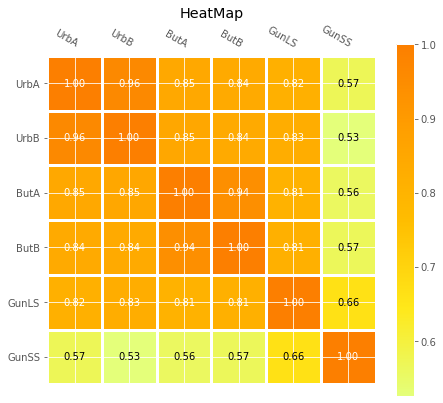

In [107]:
#columns with the data
proteomics_columns = ['Procyclic Form Vs Bloodstream Form (Tb PCFvBSF QProt SILAC)',
                     'Pcf-Bsf ratio (Tb PCF BSF QPhosProt)',
                    'Combined-PCF_light V BSF_heavy (Tb PCF BSF Prot SILAC-switch)',
                    'Combined-PCF_heavy V BSF_light (Tb PCF BSF Prot SILAC-switch)',
                         'LS (Tb927 LSvSS QProt)',
                         'SS (Tb927 LSvSS QProt)',]

rename = ['UrbA', 'UrbB', 'ButA', 
          'ButB','GunLS','GunSS']
#rename = ['1', '2', '3', '4']
temp_df = tryp_df[proteomics_columns]
temp_df.columns = rename

im, cbar, ax = scripts.heatmap(temp_df.corr().values,
                           temp_df.columns,temp_df.columns,cmap="Wistia")

texts = scripts.annotate_heatmap(im, valfmt="{x:.2f}")
plt.tight_layout()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 6)
plt.title('HeatMap')
#ax.set_xticks([]) 
#ax.set_yticks([]) 
#ax.tick_params(axis=u'both', which=u'both',length=0)
#plt.savefig(os.path.join('figures','example_1','Fig_1a.png'))
plt.show()

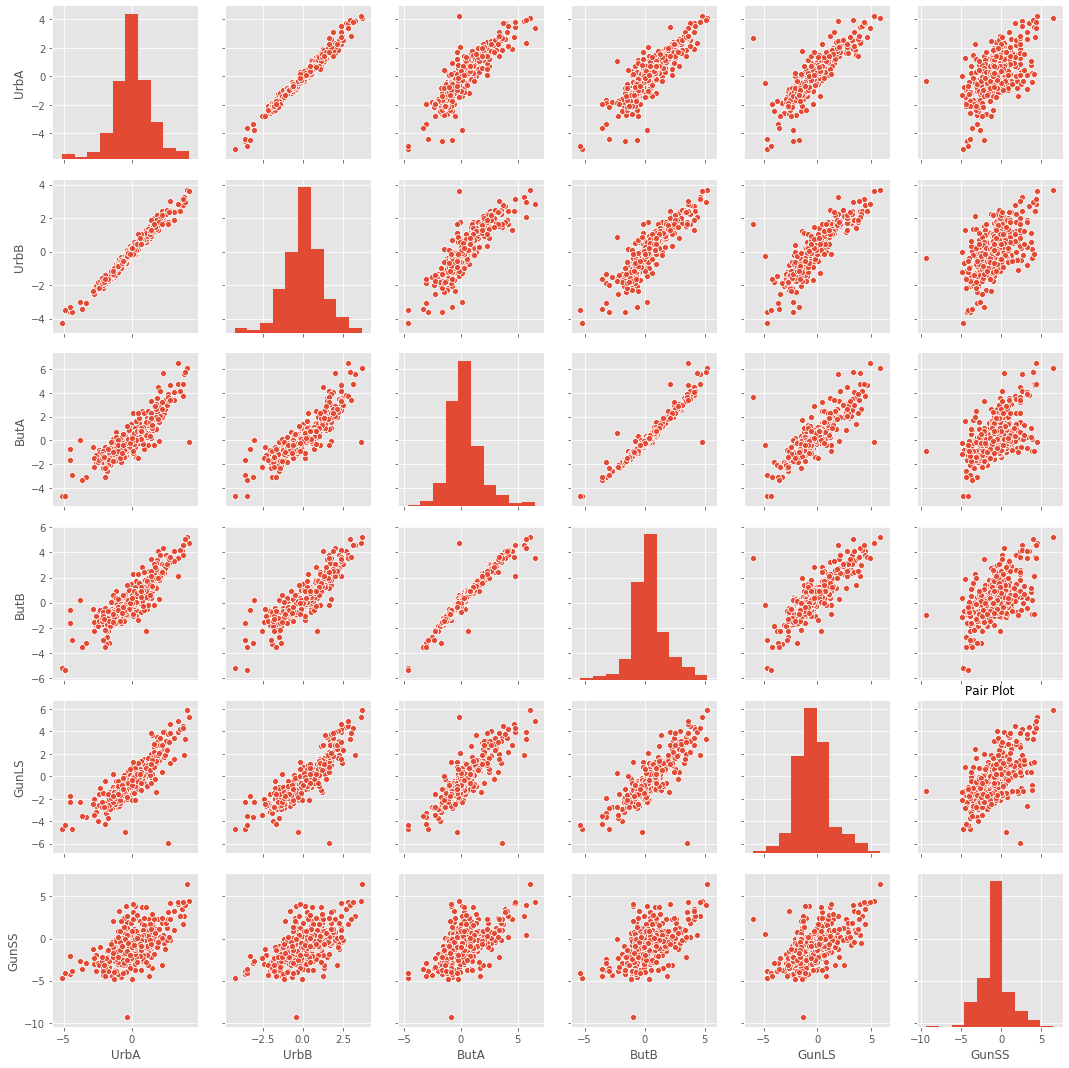

In [108]:
#random sample 500 proteins and make a scatter plot matrix
sns.pairplot(temp_df.dropna().sample(500))
plt.title('Pair Plot',fontsize=12)
plt.show()

The five datasets using the LS BSF life stage showed good experimental reproducibility (Pearson coefficients above 0.8). Unsurprisingly, the experiment using the SS BSF life stage showed a lower reproducibility with the other five LS BSF experiments; for this reason, this experiment was removed and used to create a different biological descriptor. We then averaged the experiments using the LS BSF life stage in one descriptor, after normalization using the z-scores, to avoid redundancy in the ML dataset. We also used any available data point for the average to decrease the amount of missing values. 

In [109]:
ss = StandardScaler()
del temp_df['GunSS']
temp_df=pd.DataFrame(ss.fit_transform(temp_df), 
                     columns=temp_df.columns,index=temp_df.index.values)
temp_df['merged']=temp_df.median(axis=1, skipna=True)

### Correlation of merged feature
we now evaluate the correlation of our merged feature with the starting experimental features

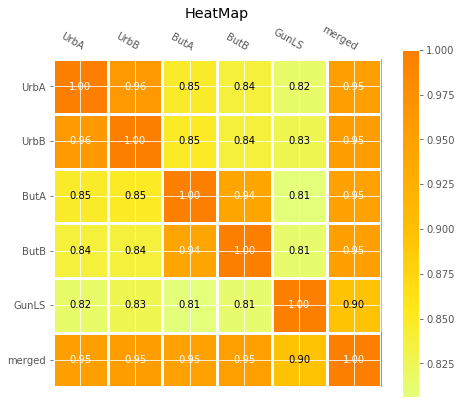

In [110]:
im, cbar, ax = scripts.heatmap(temp_df.corr().values,
                           temp_df.columns,temp_df.columns,cmap="Wistia")

texts = scripts.annotate_heatmap(im, valfmt="{x:.2f}")
plt.tight_layout()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 6)
plt.title('HeatMap')
#ax.set_xticks([]) 
#ax.set_yticks([]) 
#ax.tick_params(axis=u'both', which=u'both',length=0)
#plt.savefig(os.path.join('figures','example_1','Fig_1a.png'))
plt.show()

### BSF PCF missing data

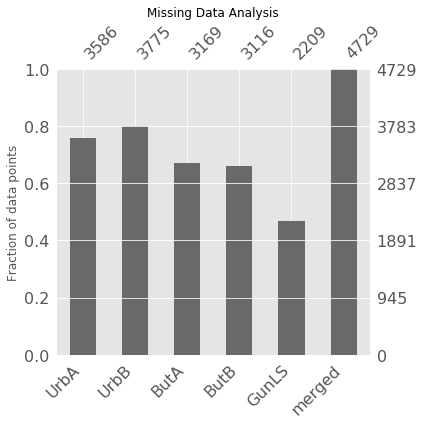

In [111]:
#visualization of missing data
ax=msno.bar(temp_df.dropna(axis=0, how='all'),figsize=(6, 6))
plt.title('Missing Data Analysis',size=12)
ax.set_ylabel('Fraction of data points',size=12)
#plt.xtickslabels(fontsize=12)
plt.tight_layout()
#plt.savefig(os.path.join('figures','example_1','Fig_2.png'))
plt.show()

The merged dataset has less missing data points

In [112]:
#adding our merged feature
ml_df['EF_merged_PCF_BSF']=temp_df['merged'].values
ml_df['EF_LSvSS']=tryp_df['SS (Tb927 LSvSS QProt)']
print(ml_df.shape)

#removing old stuff
del temp_df
gc.collect()

(11832, 3)


93493

##### keep trak of features created for sup table

In [113]:
#create the sup table
exp_feat = pd.DataFrame(columns=['Feature Name','dataset','PMID','OMICs','description'])

#populate with features
feat_name = 'EF_merged_PCF_BSF'
feat_dataset = 'Gunasekera K et al 2012, Urbaniak 2012, Urbaniak 2013, Butter et al. 2013'
feat_pmids = '22574199;23067041;23485197;26910529'
feat_type = 'Proteomics'
feat_desc = 'Z-score of Log2 fold change between the PCF and BSF Long Slender SILAC intensities, averaged across 4 experiments'
exp_feat.loc[0,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_LSvSS'
feat_dataset = 'Gunasekera K et al 2012'
feat_pmid = '22574199'
feat_type = 'Proteomics'
feat_desc = 'Log2 fold change between the PCF and BSF Short Stumpy SILAC intensities'
exp_feat.loc[1,:]=[feat_name,feat_dataset,feat_pmid,feat_type,feat_desc]
print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.head()

(2, 5)
True


,Feature Name,dataset,PMID,OMICs,description
0,EF_merged_PCF_BSF,"Gunasekera K et al 2012, Urbaniak 2012, Urbani...",22574199;23067041;23485197;26910529,Proteomics,Z-score of Log2 fold change between the PCF an...
1,EF_LSvSS,Gunasekera K et al 2012,22574199,Proteomics,Log2 fold change between the PCF and BSF Short...


### PCF Cell Cycle
Further descriptors were engineered from the changes in abundance of the PCF proteome during the cell cycle progression. From this time-course experiment, we extracted two categorical features and one continuous variable. The two categorical features reported the time point (hour) showing the maximum abundance value (MAX) and the time point showing the minimum abundance value (MIN) for each protein in the time-course experiment. The continue variable consisted of the log2 fold change between the MAX and MIN protein abundance values across the time-course experiment. The same feature extraction strategy was further applied to the time course experiments studying the changes in proteome and transcriptome abundance during the T. brucei differentiation from the BSF to PCF life stage. 

In [114]:
list(tryp_df.columns)
#final_df[[n for n in final_df.columns  if 'Tb LifeCyc Marray' in n]].head()
cols = [n for n in tryp_df.columns  if 'Tb procyclic cell cycle proteome' in n]
print (cols)
temp_df = tryp_df[cols]
temp_df = temp_df.replace(0.0, np.nan)
ml_df['EF_CellCycle_min_max'] = np.log2(
    temp_df[cols].max(axis=1,skipna=True)/temp_df[cols].min(axis=1,skipna=True))
ml_df['EF_CellCycle_max'] = temp_df[cols].idxmax(axis=1)
ml_df['EF_CellCycle_max'] = [float(str(n).split(' ')[0]) for n in ml_df['EF_CellCycle_max']]
ml_df['EF_CellCycle_min'] = temp_df[cols].idxmin(axis=1)
ml_df['EF_CellCycle_min'] = [float(str(n).split(' ')[0]) for n in ml_df['EF_CellCycle_min']]

['0.5 hr (Tb procyclic cell cycle proteome)', '3 hr (Tb procyclic cell cycle proteome)', '5 hr (Tb procyclic cell cycle proteome)', '6 hr (Tb procyclic cell cycle proteome)', '7 hr (Tb procyclic cell cycle proteome)', '8 hr (Tb procyclic cell cycle proteome)', '9 hr (Tb procyclic cell cycle proteome)', '10 hr (Tb procyclic cell cycle proteome)', '11 hr (Tb procyclic cell cycle proteome)']


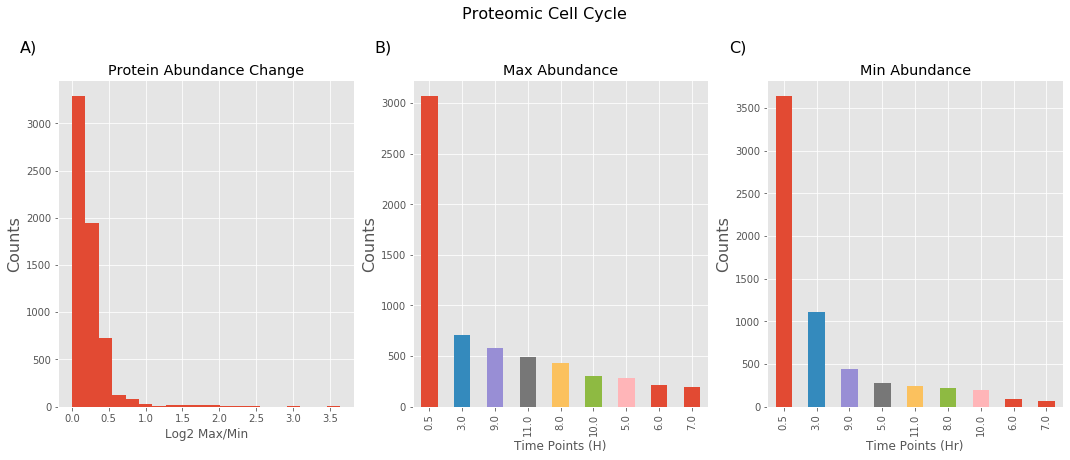

In [115]:
plt.style.use('ggplot')
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_CellCycle_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_CellCycle_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_CellCycle_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (Hr)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')


plt.suptitle('Proteomic Cell Cycle',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_3.png'))
plt.show()

##### keep trak of features created for sup table

In [116]:
feat_name = 'EF_CellCycle_min_max'
feat_dataset = 'Crozier TWM 2018'
feat_pmid= '29555687'
feat_type = 'Proteomics'
feat_desc = '''Log2 fold change between the maximum and minimum protein abundance time point
during T. brucei PCF cell cycle'''.replace('\n','')
exp_feat.loc[2,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_CellCycle_max'
feat_dataset = 'Crozier TWM 2018'
feat_type = 'Proteomics'
feat_pmid= '29555687'
feat_desc = '''The time point with the maximum protein abundance during T. brucei PCF cell cycle'''
exp_feat.loc[3,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_CellCycle_min'
feat_dataset = 'Crozier TWM 2018'
feat_type = 'Proteomics'
feat_pmid= '29555687'
feat_desc = 'The time point with the minimum protein abundance during T. brucei PCF cell cycle'
exp_feat.loc[4,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.head()

(5, 5)
True


,Feature Name,dataset,PMID,OMICs,description
0,EF_merged_PCF_BSF,"Gunasekera K et al 2012, Urbaniak 2012, Urbani...",22574199;23067041;23485197;26910529,Proteomics,Z-score of Log2 fold change between the PCF an...
1,EF_LSvSS,Gunasekera K et al 2012,22574199,Proteomics,Log2 fold change between the PCF and BSF Short...
2,EF_CellCycle_min_max,Crozier TWM 2018,22574199;23067041;23485197;26910529,Proteomics,Log2 fold change between the maximum and minim...
3,EF_CellCycle_max,Crozier TWM 2018,22574199;23067041;23485197;26910529,Proteomics,The time point with the maximum protein abunda...
4,EF_CellCycle_min,Crozier TWM 2018,22574199;23067041;23485197;26910529,Proteomics,The time point with the minimum protein abunda...


### BSF / PCF Protein Abundance
Further, we decided to create an protein abundance feature from MS data in BSF and PCF taking advantage of a recent experiment published by our laboratory. This dataset (not yet uploaded in TryTripDB), is available from the public repository <a href="https://zenodo.org/account/settings/github/repository/mtinti/wor_turnover">Zenodo</a> and uses the SILAC technique to study the BSF and PCF protein half-lives. In this work, fully labelled BSF and PCF parasites grown in medium SILAC culture media (M) were placed in light SILAC culture media (L) to follow the synthesis and degradation rate of the proteome in a time-course experiment. The experiment consisted of seven and nine time points for the BSF and PCF, respectively, with three biological replicates each. The samples of the time course experiment were also mixed 1:1 with fully labelled parasites in heavy SILAC culture media (H) to provide an internal standard for normalization. The protein intensity values of those H labelled samples were used as a proxy for protein abundance, after averaging the H intensity values across the biological replicates and the time points. 


In [117]:
bsf = pd.read_table(os.path.join('input','turnover','BSF','proteinGroups.zip'))
pcf = pd.read_table(os.path.join('input','turnover','PCF','proteinGroups.zip'))

intensity_columns = [n for n in bsf.columns if n.startswith('Intensity H') ]
bsf[intensity_columns]=bsf[intensity_columns].replace(0,np.nan)
bsf['abundance'] = np.log10(bsf[intensity_columns].mean(axis=1,skipna=True))

intensity_columns = [n for n in pcf.columns if n.startswith('Intensity H') ]
pcf[intensity_columns]=pcf[intensity_columns].replace(0,np.nan)
pcf['abundance'] = np.log10(pcf[intensity_columns].mean(axis=1, skipna=True))


temp_dict = scripts.make_dict_from_cols(bsf)
ml_df['EF_Abundance_BSF']=[temp_dict.get(n, np.nan) for n in tryp_df['Gene ID']]
temp_dict = scripts.make_dict_from_cols(pcf)
ml_df['EF_Abundance_PCF']=[temp_dict.get(n, np.nan) for n in tryp_df['Gene ID']]
print(ml_df.shape)

(11832, 8)


##### keep trak of features created for sup table

In [118]:
feat_name = 'EF_MS_Abundance_BSF'
feat_dataset = 'Tinti M and Güther MLS 2019'
feat_pmids = '31681858'
feat_type = 'Proteomics'
feat_desc = '''
The log10 eXtracted Ion Current (XIC) of the SILAC heavy BSF sample 
averaged across biological replicates and time points
'''.replace('\n','')
exp_feat.loc[5,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_MS_Abundance_PCF'
feat_dataset = 'Tinti M and Güther MLS 2019'
feat_desc = '''The log10 eXtracted Ion Current (XIC) of the SILAC heavy PCF sample 
averaged across biological replicates and time points'''.replace('\n','')
exp_feat.loc[6,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]
print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(7, 5)
True


,Feature Name,dataset,PMID,OMICs,description
2,EF_CellCycle_min_max,Crozier TWM 2018,22574199;23067041;23485197;26910529,Proteomics,Log2 fold change between the maximum and minim...
3,EF_CellCycle_max,Crozier TWM 2018,22574199;23067041;23485197;26910529,Proteomics,The time point with the maximum protein abunda...
4,EF_CellCycle_min,Crozier TWM 2018,22574199;23067041;23485197;26910529,Proteomics,The time point with the minimum protein abunda...
5,EF_MS_Abundance_BSF,Tinti M and Güther MLS 2019,31681858,Proteomics,The log10 eXtracted Ion Current (XIC) of the S...
6,EF_MS_Abundance_PCF,Tinti M and Güther MLS 2019,31681858,Proteomics,The log10 eXtracted Ion Current (XIC) of the S...


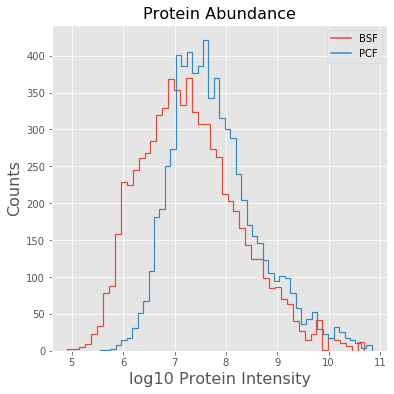

In [119]:
fig,ax=plt.subplots(figsize=(6,6))
from matplotlib.lines import Line2D
ml_df['EF_Abundance_BSF'].plot(kind='hist',histtype='step', ax=ax, label='BSF',linewidth=1.2,bins=50)
ml_df['EF_Abundance_PCF'].plot(kind='hist',histtype='step', ax=ax, label='PCF',linewidth=1.2,bins=50)
plt.xlabel('log10 Protein Intensity', fontsize=16)
plt.ylabel('Counts', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels)
plt.title('Protein Abundance',fontsize=16)
#plt.savefig(os.path.join('figures','example_1','Fig_4.png'))
plt.show()

### PCF Protein Complexes

Another experiment from our laboratory (not yet uploaded in TriTrypDB) aimed at the identification of T. brucei protein complexes using size-exclusion chromatography (SEC) and mass spectrometry. Briefly, PCF cells were prepared for native protein complex analysis by sonication lysis. The resulting lysates were fractionated separating protein complexes based on their size and shape, and the fractions were analysed by mass spectrometry. From this dataset, we first focus on the experiment using the 30 nm pore column (SEC 300), that efficiently separates protein complexes in the range from 8 kDa to 1.2 MDa. 

In [120]:
#regression to compute the predicted MW 
#from the chromatography fraction
def find_weight(f):
    from pylab import polyfit
    from pylab import poly1d
    x = [8, 13, 21, 25, 31, 39, 44]
    y = [np.log(n) for n in [1200,660,450,150,70,21,8]]
    fit = polyfit(x, y, 1)
    fit_fn = poly1d(fit)
    return np.exp(fit_fn(f))

#parse MaxQuant output
infile=os.path.join('input','protein_complexes','proteinGroups_SEC300.zip')
indf = pd.read_table(infile)
temp = indf[[n for n in indf.columns if 'LFQ intensity' in n ]]
#print(temp.shape)
df_list = []
#using dataset with good reproducibility (see paper)
for good_id in ['E3017','E3019','E3021','E3023']:
    temp = indf[[n for n in temp.columns if good_id in n ]]
    temp.columns = [n.split('_')[-1] for n in temp.columns]
    temp['ids']=temp.index.values
    df_list.append(temp)
df_list = pd.concat(df_list)
df_list=df_list.groupby('ids').mean()
df_list['max']=df_list.idxmax(axis=1)
df_list['apparent_weigth'] = [find_weight(int(f)) for f in df_list['max']]
df_list=pd.concat([df_list,indf[['Protein IDs']] ] ,axis=1)
df_list.head()

,01,02,03,04,05,06,07,08,09,10,...,42,43,44,45,46,47,48,max,apparent_weigth,Protein IDs
ids,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,255.832140,CON__A2A5Y0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,189240000.0,48,5.946440,CON__ENSEMBL:ENSBTAP00000007350;CON__P01030
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,63.515795,CON__ENSEMBL:ENSBTAP00000018229;CON__Q3MHN5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01,4150.513573,CON__ENSEMBL:ENSBTAP00000018574
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,678.432213,CON__ENSEMBL:ENSBTAP00000024146


In [121]:
#extract firsth feature
map_dict = scripts.make_dict_from_cols(df_list,
                                       key='Protein IDs', 
                                       value='apparent_weigth')
tryp_df['apparent_weigth']=[map_dict.get(n,np.nan) for n in tryp_df['Gene ID']]
ml_df['EF_MW_fc'] = tryp_df['apparent_weigth']/(tryp_df['Molecular Weight']/1000)


##### keep trak of features created for sup table

In [122]:
feat_name = 'EF_MW_fc'
feat_dataset = 'Crozier TWM 2017'
feat_type = 'Proteomics'
feat_pmids = '29042480'
feat_desc = '''
The log2 fold change between the computed molecular weight and the observed
molecular weight in size exclusion chromatografy of the PCF proteins'
'''.replace('\n','')
exp_feat.loc[7,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]
print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(8, 5)
True


,Feature Name,dataset,PMID,OMICs,description
3,EF_CellCycle_max,Crozier TWM 2018,22574199;23067041;23485197;26910529,Proteomics,The time point with the maximum protein abunda...
4,EF_CellCycle_min,Crozier TWM 2018,22574199;23067041;23485197;26910529,Proteomics,The time point with the minimum protein abunda...
5,EF_MS_Abundance_BSF,Tinti M and Güther MLS 2019,31681858,Proteomics,The log10 eXtracted Ion Current (XIC) of the S...
6,EF_MS_Abundance_PCF,Tinti M and Güther MLS 2019,31681858,Proteomics,The log10 eXtracted Ion Current (XIC) of the S...
7,EF_MW_fc,Crozier TWM 2017,29042480,Proteomics,The log2 fold change between the computed mole...


Thanks to protein molecular weight (MW) standards, it is then possible to infer the apparent MW of the proteins in each of the SEC 300 elution fractions. Consequently, we assign to each protein an apparent MW corresponding to the fraction showing the maximum protein abundance. The log2 fold change between the apparent MW and the MW of the protein computed from the primary sequence was taken as a descriptor to describe the molecular state of protein, in high MW complexes (log2 fold change > 0), monomer (log2 fold change around 0) or degraded (log2 fold change < 0). 

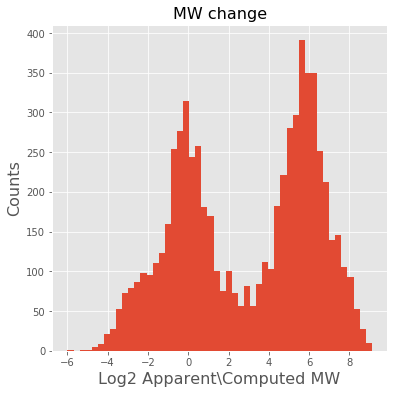

In [123]:
np.log2(ml_df['EF_MW_fc']).plot(kind='hist',figsize=(6,6), bins=50)
plt.title('MW change', fontsize=16)
plt.xlabel('Log2 Apparent\Computed MW',fontsize=16)
plt.ylabel('Counts', fontsize=16)
#plt.savefig(os.path.join('figures','example_1','Fig_5.png'))
plt.show()

In [124]:
#missing data replaced with 0
ml_df['EF_MW_fc'] = ml_df['EF_MW_fc'].fillna(0)

Finally, we created a simple binary feature describing if a protein belongs (1) or does not belong (0) to a protein complex based on the analysis reported in Crozier et al.

In [125]:
#extract second feature
#this extract the predicted protein complexes from the paper
temp = open(os.path.join('input', 'protein_complexes', 'final_complexes_mcp.txt'))
complex_set = []
for line in temp:
    prots = line.split('\t')
    prots = [n.strip() for n in prots]
    complex_set+=prots
complex_set=set(complex_set)
ml_df['EF_in_complex'] = [1 if n in complex_set else np.nan 
                          for n in ml_df['Gene ID']]
ml_df['EF_in_complex'].value_counts()
ml_df['EF_in_complex']=ml_df['EF_in_complex'].fillna(-1)

In [126]:
feat_name = 'EF_in_complex'
feat_dataset = 'Crozier TWM 2017'
feat_desc = '''
Binary value describing if a protein was detected (1) or not (0) in a portein complex'
'''.replace('\n','')
exp_feat.loc[8,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]
print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(9, 5)
True


,Feature Name,dataset,PMID,OMICs,description
4,EF_CellCycle_min,Crozier TWM 2018,22574199;23067041;23485197;26910529,Proteomics,The time point with the minimum protein abunda...
5,EF_MS_Abundance_BSF,Tinti M and Güther MLS 2019,31681858,Proteomics,The log10 eXtracted Ion Current (XIC) of the S...
6,EF_MS_Abundance_PCF,Tinti M and Güther MLS 2019,31681858,Proteomics,The log10 eXtracted Ion Current (XIC) of the S...
7,EF_MW_fc,Crozier TWM 2017,29042480,Proteomics,The log2 fold change between the computed mole...
8,EF_in_complex,Crozier TWM 2017,29042480,Proteomics,Binary value describing if a protein was detec...


### Differentiation From BSF to PCF
Dejung M, 2016<p>
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/26910529  ">26910529 </a> and <a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_1ec24003f1">TryTripDB</a>



During the life cycle of the African trypanosomes in the mammalian host, the trypanosomes undergo a developmental transition from a rapidly dividing long slender stage (LS) to a non-dividing short stumpy stage (SS). The LS stage is well adapted for growth in the mammalian host whereas the SS stage appears pre-adapted for life in the vector. In this dataset, parasites were induced to differentiate from the short stumpy (SS) form to the procyclic form (PF) using 6 mM citrate/cis-aconitate. Parasites were harvested at 0, 2, 4, 6, 12, 24, and 48 h after treatment, and established PF and long slender (LS) forms were also collected.

<b> The TriTrypDB dataset appears to miss the SS </b> (short stumpy stage) present in the original articles. See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4765897/figure/ppat.1005439.g001/

In [127]:
#i'm going to code the LS stage as -1 hour and PF stage as +100 hour
#as they shuld represent the earliest and the latest time point in the series'
tryp_df.rename({'LS (tbru differ proteome)':
                 '-1 LS (tbru differ proteome)',
                 'PF (tbru differ proteome)':
                 '100 PF (tbru differ proteome)'},
                inplace=True,axis=1)
cols = [n for n in tryp_df.columns  if 'tbru differ proteome' in n]
cols

['-1 LS (tbru differ proteome)',
 '0 hr (tbru differ proteome)',
 '2 hr (tbru differ proteome)',
 '4 hr (tbru differ proteome)',
 '6 hr (tbru differ proteome)',
 '12 hr (tbru differ proteome)',
 '24 hr (tbru differ proteome)',
 '48 hr (tbru differ proteome)',
 '100 PF (tbru differ proteome)']

In [128]:
temp_df = tryp_df[cols]
temp_df = temp_df.replace(0.0, np.nan)
ml_df['EF_prot_BSF_to_PCF_1_min_max'] = np.log2(
    temp_df[cols].max(axis=1,skipna=True)/temp_df[cols].min(axis=1,skipna=True))
ml_df['EF_prot_BSF_to_PCF_1_max'] = temp_df[cols].idxmax(axis=1)
ml_df['EF_prot_BSF_to_PCF_1_max'] = [float(str(n).split(' ')[0]) 
                                     for n in ml_df['EF_prot_BSF_to_PCF_1_max']]
ml_df['EF_prot_BSF_to_PCF_1_min'] = temp_df[cols].idxmin(axis=1)
ml_df['EF_prot_BSF_to_PCF_1_min'] = [float(str(n).split(' ')[0]) 
                                     for n in ml_df['EF_prot_BSF_to_PCF_1_min']]

#ml_df['prot_BSF_to_PCF_1_min']=ml_df['prot_BSF_to_PCF_1_min'].astype('category')
#ml_df['prot_BSF_to_PCF_1_max']=ml_df['prot_BSF_to_PCF_1_max'].astype('category')

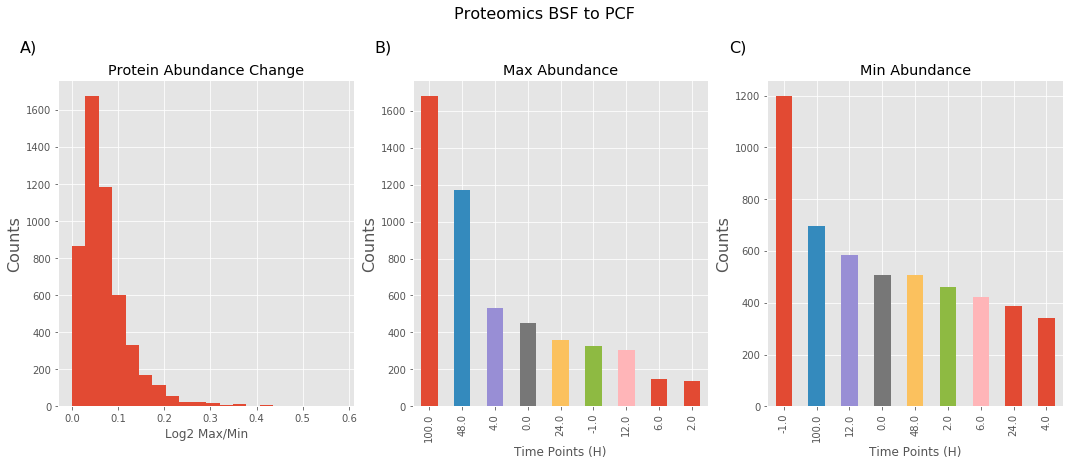

In [129]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_prot_BSF_to_PCF_1_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_prot_BSF_to_PCF_1_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_prot_BSF_to_PCF_1_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')


plt.suptitle('Proteomics BSF to PCF',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_6.png'))
plt.show()

##### keep trak of features created for sup table

In [130]:
feat_pmids = '26910529'
feat_type = 'Proteomics'
feat_name = 'EF_prot_BSF_to_PCF_1_min_max'
feat_dataset = 'Dejung M, 2016'
feat_desc = '''Log2 fold change between the maximum and minimum protein abundance
time points during the PCF to BSF differentiation'''.replace('\n','')
exp_feat.loc[9,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_prot_BSF_to_PCF_1_max'
feat_dataset = 'Dejung M, 2016'
feat_desc = 'The time point with the maximum protein abundance during the PCF to BSF differentiation'
exp_feat.loc[10,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_prot_BSF_to_PCF_1_min'
feat_dataset = 'Dejung M, 2016'
feat_desc = 'The time point with the minimum protein abundance during the PCF to BSF differentiation'
exp_feat.loc[11,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(12, 5)
True


,Feature Name,dataset,PMID,OMICs,description
7,EF_MW_fc,Crozier TWM 2017,29042480,Proteomics,The log2 fold change between the computed mole...
8,EF_in_complex,Crozier TWM 2017,29042480,Proteomics,Binary value describing if a protein was detec...
9,EF_prot_BSF_to_PCF_1_min_max,"Dejung M, 2016",26910529,Proteomics,Log2 fold change between the maximum and minim...
10,EF_prot_BSF_to_PCF_1_max,"Dejung M, 2016",26910529,Proteomics,The time point with the maximum protein abunda...
11,EF_prot_BSF_to_PCF_1_min,"Dejung M, 2016",26910529,Proteomics,The time point with the minimum protein abunda...


## Processing of trascriptomics data

### microarray

#### DNA microarray BSF to PCF 1
<p>
Jensen BC et al, 2009

Differentiation from stumpy to tsetse-midgut procyclic forms
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/19840382 ">19840382</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_2e9f1cbf33">TryTripDB</a>

Whole genome comparison of RNA levels for both protein coding genes and structural RNAs in five different life-cycle stages: cultured bloodstream (Blood Form), in vivo slender bloodstream (Slender), in vivo stumpy bloodstream (Stumpy), log-phase procyclic culture (PCF Log) and stationary-phase procyclic culture forms (PCF Stat)   

In [131]:
tryp_df.rename({'Blood Form (Tb LifeCyc Marray)':
                '1 Blood Form (Tb LifeCyc Marray)',
                
                'Slender (Tb LifeCyc Marray)':
                 '2 Slender (Tb LifeCyc Marray)',

                'Stumpy (Tb LifeCyc Marray)':
                 '3 Stumpy (Tb LifeCyc Marray)',

                 'PCF Log (Tb LifeCyc Marray)':
                 '4 Stumpy (Tb LifeCyc Marray)',
                 
                'PCF Stat (Tb LifeCyc Marray)':
                 '5 PCF Stat (Tb LifeCyc Marray)',
                },
                inplace=True,axis=1)

cols = [n for n in tryp_df.columns  if 'Tb LifeCyc Marray' in n]
cols

['1 Blood Form (Tb LifeCyc Marray)',
 '2 Slender (Tb LifeCyc Marray)',
 '3 Stumpy (Tb LifeCyc Marray)',
 '4 Stumpy (Tb LifeCyc Marray)',
 '5 PCF Stat (Tb LifeCyc Marray)']

In [132]:
ml_df['EF_ma_BSF_to_PCF_1_min_max'] = np.log2(
    tryp_df[cols].max(axis=1,skipna=True)/tryp_df[cols].min(axis=1,skipna=True))
ml_df['EF_ma_BSF_to_PCF_1_max'] = tryp_df[cols].idxmax(axis=1)
ml_df['EF_ma_BSF_to_PCF_1_max'] = [float(str(n).split(' ')[0]) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_1_max']]
ml_df['EF_ma_BSF_to_PCF_1_min'] = tryp_df[cols].idxmin(axis=1)
ml_df['EF_ma_BSF_to_PCF_1_min'] = [float(str(n).split(' ')[0]) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_1_min']]

#ml_df['ma_BSF_to_PCF_1_max']=ml_df['ma_BSF_to_PCF_1_max'].astype('category')
#ml_df['ma_BSF_to_PCF_1_min']=ml_df['ma_BSF_to_PCF_1_min'].astype('category')

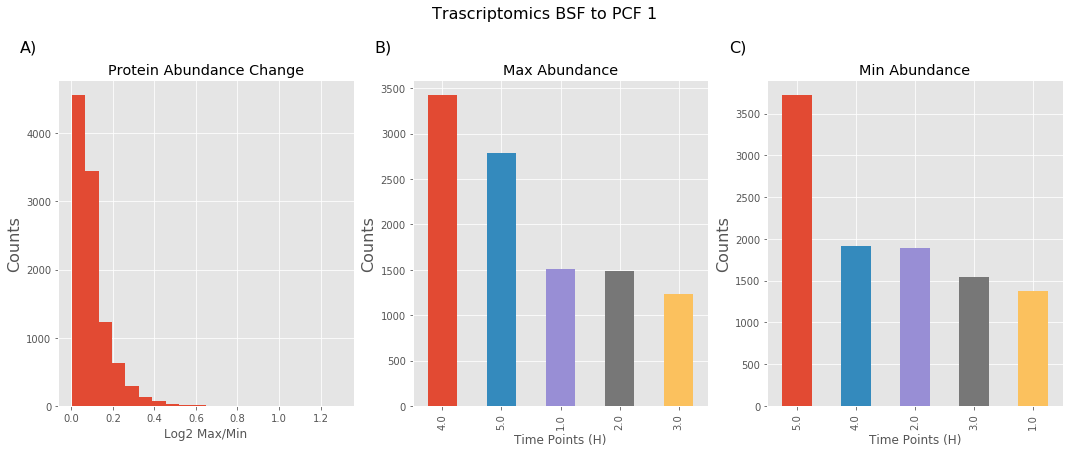

In [133]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_ma_BSF_to_PCF_1_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_ma_BSF_to_PCF_1_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_ma_BSF_to_PCF_1_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')


plt.suptitle('Trascriptomics BSF to PCF 1',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_7.png'))
plt.show()

##### keep trak of features created for sup table

In [134]:
feat_name = 'EF_ma_BSF_to_PCF_1_min_max'
feat_dataset = 'Jensen BC et al, 2009'
feat_pmids = '19840382'
feat_type = 'Trascriptomics / Microarrays'
feat_desc = '''Log2 fold change between the maximum and minimum mRNA abundance
time points during the PCF to BSF differentiation'''.replace('\n','')
exp_feat.loc[12,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_ma_BSF_to_PCF_1_max'
feat_desc = 'The time point with the maximum mRNA abundance during the PCF to BSF differentiation'
exp_feat.loc[13,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_ma_BSF_to_PCF_1_min'
feat_desc = 'The time point with the minimum mRNA abundance during the PCF to BSF differentiation'
exp_feat.loc[14,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(15, 5)
True


,Feature Name,dataset,PMID,OMICs,description
10,EF_prot_BSF_to_PCF_1_max,"Dejung M, 2016",26910529,Proteomics,The time point with the maximum protein abunda...
11,EF_prot_BSF_to_PCF_1_min,"Dejung M, 2016",26910529,Proteomics,The time point with the minimum protein abunda...
12,EF_ma_BSF_to_PCF_1_min_max,"Jensen BC et al, 2009",19840382,Trascriptomics / Microarrays,Log2 fold change between the maximum and minim...
13,EF_ma_BSF_to_PCF_1_max,"Jensen BC et al, 2009",19840382,Trascriptomics / Microarrays,The time point with the maximum mRNA abundance...
14,EF_ma_BSF_to_PCF_1_min,"Jensen BC et al, 2009",19840382,Trascriptomics / Microarrays,The time point with the minimum mRNA abundance...


#### DNA microarray BSF to PCF 2
Queiroz R et al 2009<p>
Gene Expression profiling during in vitro differentiation from cultured bloodstream forms to procyclic forms
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/19857263">19857263</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_0c4be69d67">TryTripDB</a>

In [135]:
tryp_df.rename({'bf-ld (Tb cBSFtoPCF Marray)':
                 '-2 bf-ld (Tb cBSFtoPCF Marray)',
                'bf-hd (Tb cBSFtoPCF Marray)':
                 '-1 bf-hd (Tb cBSFtoPCF Marray)'
                },
                inplace=True,axis=1)

cols = [n for n in tryp_df.columns  if 'Tb cBSFtoPCF Marray' in n]
print (cols)

['-2 bf-ld (Tb cBSFtoPCF Marray)', '-1 bf-hd (Tb cBSFtoPCF Marray)', '0.5hr (Tb cBSFtoPCF Marray)', '1hr (Tb cBSFtoPCF Marray)', '12hr (Tb cBSFtoPCF Marray)', '24hr (Tb cBSFtoPCF Marray)', '48hr (Tb cBSFtoPCF Marray)', '72hr (Tb cBSFtoPCF Marray)']


In [136]:
ml_df['EF_ma_BSF_to_PCF_2_min_max'] = np.log2(
    np.exp(tryp_df[cols].max(axis=1,
                             skipna=True))/np.exp(tryp_df[cols].min(axis=1,
                                                                    skipna=True)))
ml_df['EF_ma_BSF_to_PCF_2_max'] = tryp_df[cols].idxmax(axis=1)
ml_df['EF_ma_BSF_to_PCF_2_max'] = [float(str(n).split(' ')[0].replace('hr','')) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_2_max']]
ml_df['EF_ma_BSF_to_PCF_2_min'] = tryp_df[cols].idxmin(axis=1)
ml_df['EF_ma_BSF_to_PCF_2_min'] = [float(str(n).split(' ')[0].replace('hr','')) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_2_min']]

#ml_df['ma_BSF_to_PCF_2_max']=ml_df['ma_BSF_to_PCF_2_max'].astype('category')
#ml_df['ma_BSF_to_PCF_2_min']=ml_df['ma_BSF_to_PCF_2_min'].astype('category')

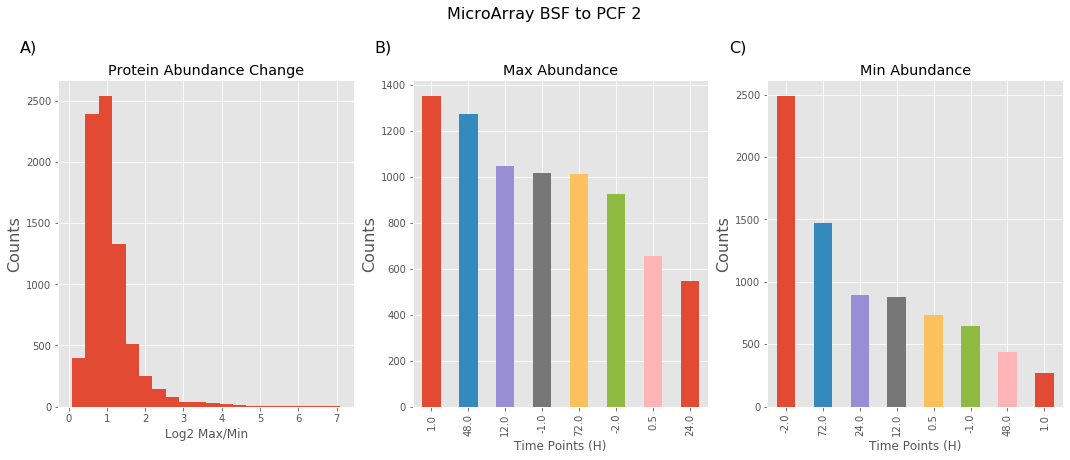

In [137]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_ma_BSF_to_PCF_2_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_ma_BSF_to_PCF_2_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_ma_BSF_to_PCF_2_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')


plt.suptitle('MicroArray BSF to PCF 2',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_8.png'))
plt.show()

##### keep trak of features created for sup table

In [138]:
feat_name = 'EF_ma_BSF_to_PCF_2_min_max'
feat_dataset = 'Queiroz R et al 2009, 2009'
feat_pmids = '19857263'
feat_desc = '''Log2 fold change between the maximum and minimum mRNA abundance
time points during the PCF to BSF differentiation'''.replace('\n','')
exp_feat.loc[15,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_ma_BSF_to_PCF_2_max'
feat_desc = 'The time point with the maximum mRNA abundance during the PCF to BSF differentiation'
exp_feat.loc[16,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_ma_BSF_to_PCF_2_min'
feat_desc = 'The time point with the minimum mRNA abundance during the PCF to BSF differentiation'
exp_feat.loc[17,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(18, 5)
True


,Feature Name,dataset,PMID,OMICs,description
13,EF_ma_BSF_to_PCF_1_max,"Jensen BC et al, 2009",19840382,Trascriptomics / Microarrays,The time point with the maximum mRNA abundance...
14,EF_ma_BSF_to_PCF_1_min,"Jensen BC et al, 2009",19840382,Trascriptomics / Microarrays,The time point with the minimum mRNA abundance...
15,EF_ma_BSF_to_PCF_2_min_max,"Queiroz R et al 2009, 2009",19857263,Trascriptomics / Microarrays,Log2 fold change between the maximum and minim...
16,EF_ma_BSF_to_PCF_2_max,"Queiroz R et al 2009, 2009",19857263,Trascriptomics / Microarrays,The time point with the maximum mRNA abundance...
17,EF_ma_BSF_to_PCF_2_min,"Queiroz R et al 2009, 2009",19857263,Trascriptomics / Microarrays,The time point with the minimum mRNA abundance...


In [139]:
print(ml_df.shape)

(11832, 19)


#### DNA microarray BSF to PCF 3
Kabani et al. 2009.


PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/19747379 ">19747379</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_b7dc54ebad">TryTripDB</a>

mRNA expression profiles of T. brucei AnTat1.1 slender and stumpy bloodstream stages, as well as 4 time points during the transition of the stumpy to the procyclic life-cycle stage

1. Slender bloodstream form: harvested 3 days post-infection of cyclophosphamide treated mice
2. 0 h time point (Stumpy bloodstream form): harvested 6 days post-infection of cyclophosphamide treated mice
3. 1 h time point: harvested 1 hour after initiating differentiation with cis-aconitate
4. 6 h time point: harvested 6 hour after initiating differentiation with cis-aconitate
5. 18 h time point: harvested 18 hour after initiating differentiation with cis-aconitate
6. 48 h time point: harvested 48 hour after initiating differentiation with cis-aconitate

In [140]:
#set the Slender as the erliest time point
tryp_df.rename({'Slender (Tb LifeCyc Diff Marray)':
                 '-1 Slender (Tb LifeCyc Diff Marray)'},
                inplace=True,axis=1)
cols = [n for n in tryp_df.columns  if 'Tb LifeCyc Diff Marray' in n]
cols

['-1 Slender (Tb LifeCyc Diff Marray)',
 '0 hr (Tb LifeCyc Diff Marray)',
 '1 hr (Tb LifeCyc Diff Marray)',
 '6 hr (Tb LifeCyc Diff Marray)',
 '18 hr (Tb LifeCyc Diff Marray)',
 '48 hr (Tb LifeCyc Diff Marray)']

In [141]:
ml_df['EF_ma_BSF_to_PCF_3_min_max'] = np.log2(
    tryp_df[cols].max(axis=1,skipna=True)/tryp_df[cols].min(axis=1,skipna=True))
ml_df['EF_ma_BSF_to_PCF_3_max'] = tryp_df[cols].idxmax(axis=1)
ml_df['EF_ma_BSF_to_PCF_3_max'] = [float(str(n).split(' ')[0]) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_3_max']]
ml_df['EF_ma_BSF_to_PCF_3_min'] = tryp_df[cols].idxmin(axis=1)
ml_df['EF_ma_BSF_to_PCF_3_min'] = [float(str(n).split(' ')[0]) 
                                   for n in ml_df['EF_ma_BSF_to_PCF_3_min']]

#ml_df['ma_BSF_to_PCF_1_max']=ml_df['ma_BSF_to_PCF_1_max'].astype('category')
#ml_df['ma_BSF_to_PCF_1_min']=ml_df['ma_BSF_to_PCF_1_min'].astype('category')

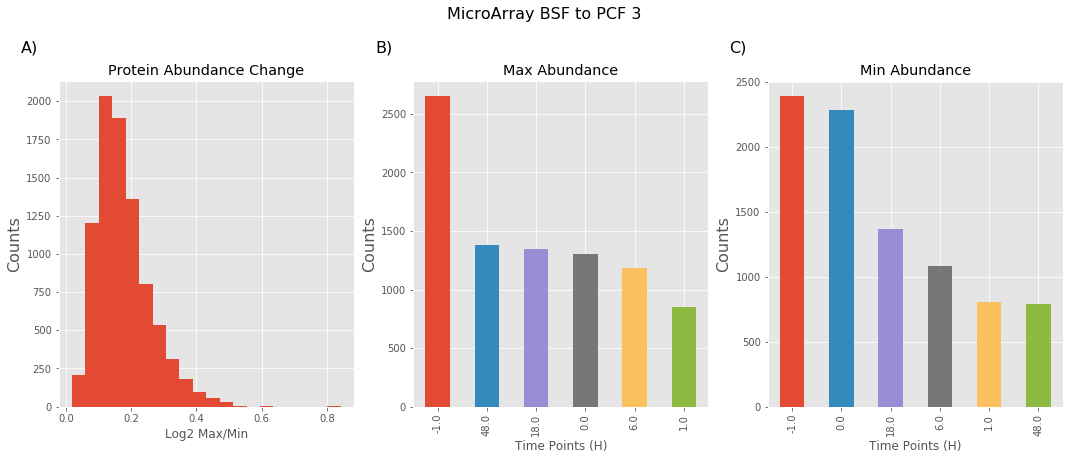

In [142]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_ma_BSF_to_PCF_3_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_ma_BSF_to_PCF_3_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_ma_BSF_to_PCF_3_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')


plt.suptitle('MicroArray BSF to PCF 3',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_9.png'))
plt.show()

##### keep trak of features created for sup table

In [143]:
feat_name = 'EF_ma_BSF_to_PCF_3_min_max'
feat_dataset = 'Kabani et al, 2009'
feat_pmids = '19747379'

feat_desc = '''Log2 fold change between the maximum and minimum mRNA abundance
time points during the PCF to BSF differentiation'''.replace('\n','')
exp_feat.loc[18,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_ma_BSF_to_PCF_3_max'
feat_desc = 'The time point with the maximum mRNA abundance during the PCF to BSF differentiation'
exp_feat.loc[19,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_ma_BSF_to_PCF_3_min'
feat_desc = 'The time point with the minimum mRNA abundance during the PCF to BSF differentiation'
exp_feat.loc[20,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(21, 5)
True


,Feature Name,dataset,PMID,OMICs,description
16,EF_ma_BSF_to_PCF_2_max,"Queiroz R et al 2009, 2009",19857263,Trascriptomics / Microarrays,The time point with the maximum mRNA abundance...
17,EF_ma_BSF_to_PCF_2_min,"Queiroz R et al 2009, 2009",19857263,Trascriptomics / Microarrays,The time point with the minimum mRNA abundance...
18,EF_ma_BSF_to_PCF_3_min_max,"Kabani et al, 2009",19747379,Trascriptomics / Microarrays,Log2 fold change between the maximum and minim...
19,EF_ma_BSF_to_PCF_3_max,"Kabani et al, 2009",19747379,Trascriptomics / Microarrays,The time point with the maximum mRNA abundance...
20,EF_ma_BSF_to_PCF_3_min,"Kabani et al, 2009",19747379,Trascriptomics / Microarrays,The time point with the minimum mRNA abundance...


### RNA-Seq

#### RNA-Seq mouse blood vs gonadal fat
Trindade S, 2016<p>
Transcriptomes of T brucei parasites isolated from mouse blood and gonadal fat
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/27237364 ">27237364</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_917e265ce7">TryTripDB</a>
    
We also assemble biological descriptors to capture the differential expressed genes between the BSF and ATF (adipose tissue forms) life stages. For this experiment, we computed the log2 fold changes between the ATF and BSF samples.     

In [144]:
#average blood and fat replicates
cols_fat = [n for n in tryp_df.columns  if 'Tbru Adipose RNASeq' in n and 'Fat' in n]
cols_blood = [n for n in tryp_df.columns  if 'Tbru Adipose RNASeq' in n and 'Blood' in n]

tryp_df['fat_mean'] = tryp_df[cols_fat].mean(skipna=True, axis=1)
tryp_df['blood_mean'] = tryp_df[cols_blood].mean(skipna=True, axis=1)
print(tryp_df[['fat_mean','blood_mean']].shape)
#compute FC fat / blood 
ml_df['EF_RNASeq_adipose_blood']=np.log2(tryp_df['fat_mean'].replace(0,np.nan)/tryp_df['blood_mean'].replace(0,np.nan))

(11832, 2)


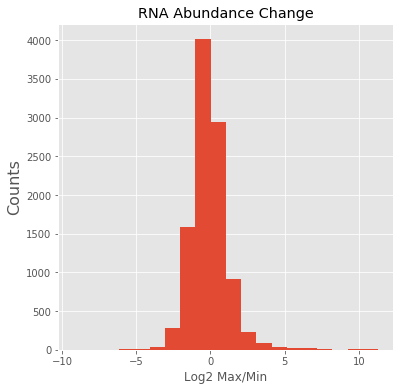

In [145]:
fig,ax=plt.subplots(figsize=(6,6))
ml_df['EF_RNASeq_adipose_blood'].plot(kind='hist', bins=20,ax=ax)
ax.set_xlabel('Log2 Max/Min',fontsize=12)
ax.set_ylabel('Counts', fontsize=16)
ax.set_title('RNA Abundance Change')
#plt.savefig(os.path.join('figures','example_1','Fig_10.png'))
plt.show()

##### keep trak of features created for sup table

In [146]:
feat_name = 'EF_RNASeq_adipose_blood'
feat_dataset = 'Trindade S, 2016'
feat_pmids = '27237364'
feat_type = 'Trascriptomics / RNA-seq'
feat_desc = 'Log2 fold changes between the ATF and BSF mRNA abundance'
exp_feat.loc[21,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(22, 5)
True


,Feature Name,dataset,PMID,OMICs,description
17,EF_ma_BSF_to_PCF_2_min,"Queiroz R et al 2009, 2009",19857263,Trascriptomics / Microarrays,The time point with the minimum mRNA abundance...
18,EF_ma_BSF_to_PCF_3_min_max,"Kabani et al, 2009",19747379,Trascriptomics / Microarrays,Log2 fold change between the maximum and minim...
19,EF_ma_BSF_to_PCF_3_max,"Kabani et al, 2009",19747379,Trascriptomics / Microarrays,The time point with the maximum mRNA abundance...
20,EF_ma_BSF_to_PCF_3_min,"Kabani et al, 2009",19747379,Trascriptomics / Microarrays,The time point with the minimum mRNA abundance...
21,EF_RNASeq_adipose_blood,"Trindade S, 2016",27237364,Trascriptomics / RNA-seq,Log2 fold changes between the ATF and BSF mRNA...


In [147]:
print(ml_df.shape)

(11832, 23)


#### RNA-Seq glucose response
Qiu Y, 2018<p>
RNA seq analysis with or without added glucose and proline/threonine
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/30381351">30381351</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_cf6d4532c7">TryTripDB</a>
   
We also considered the response of the parasites to glucose depletion by computing three features: The log2 fold changes between the RNA-seq read counts of 1) glucose-fed SS BSF versus glucose-starved SS  BSF parasites, 2) glucose-fed LS BSF parasites versus glucose-fed SS BSF parasites and 3) glucose-fed LS BSF parasites versus glucose-starved SS BSF parasites.

In [148]:



temp_1 = tryp_df['sense - LS + gluc - unique only'].replace(0,np.nan)
temp_2 = tryp_df['sense - SS - gluc - unique only'].replace(0,np.nan)
ml_df['EF_fc_glucose_1'] = np.log2(temp_1/temp_2)

#we used only the fold change in SS
temp_1 = tryp_df['sense - SS + gluc - unique only'].replace(0,np.nan)
temp_2 = tryp_df['sense - SS - gluc - unique only'].replace(0,np.nan)
ml_df['EF_fc_glucose_2'] = np.log2(temp_1/temp_2)

temp_1 = tryp_df['sense - LS + gluc - unique only'].replace(0,np.nan)
temp_2 = tryp_df['sense - SS + gluc - unique only'].replace(0,np.nan)
ml_df['EF_fc_glucose_3'] = np.log2(temp_1/temp_2)


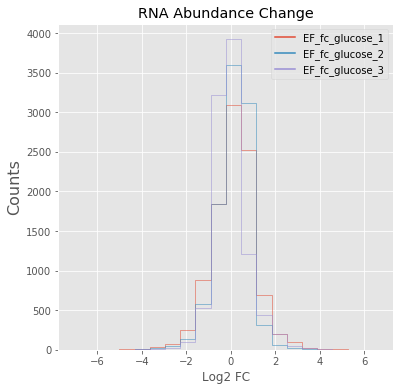

In [149]:
fig,ax=plt.subplots(figsize=(6,6))
ml_df[['EF_fc_glucose_1',
       'EF_fc_glucose_2',
      'EF_fc_glucose_3',]].plot(kind='hist',histtype='step', bins=20,ax=ax)

ax.set_xlabel('Log2 FC',fontsize=12)
ax.set_ylabel('Counts', fontsize=16)
ax.set_title('RNA Abundance Change')
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels)

#plt.savefig(os.path.join('figures','example_1','Fig_11.png'))
plt.show()

###### keep trak of features created for sup table

In [150]:
feat_name = 'EF_fc_glucose_1'
feat_dataset = 'Qiu Y, 2018'
feat_pmids = '30381351'
feat_desc = 'Log2 fold changes between long slender BSF glucose-fed  and glucose-fed short stumpy BSF'
exp_feat.loc[22,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_fc_glucose_2'
feat_desc = 'Log2 fold changes between glucose-fed  and glucose-starved short stumpy BSF'
exp_feat.loc[23,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]


feat_name = 'EF_fc_glucose_3'
feat_desc = 'Log2 fold changes between long slender BSF glucose-fed  and glucose-starved short stumpy BSF'
exp_feat.loc[24,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(25, 5)
True


,Feature Name,dataset,PMID,OMICs,description
20,EF_ma_BSF_to_PCF_3_min,"Kabani et al, 2009",19747379,Trascriptomics / Microarrays,The time point with the minimum mRNA abundance...
21,EF_RNASeq_adipose_blood,"Trindade S, 2016",27237364,Trascriptomics / RNA-seq,Log2 fold changes between the ATF and BSF mRNA...
22,EF_fc_glucose_1,"Qiu Y, 2018",30381351,Trascriptomics / RNA-seq,Log2 fold changes between long slender BSF glu...
23,EF_fc_glucose_2,"Qiu Y, 2018",30381351,Trascriptomics / RNA-seq,Log2 fold changes between glucose-fed and glu...
24,EF_fc_glucose_3,"Qiu Y, 2018",30381351,Trascriptomics / RNA-seq,Log2 fold changes between long slender BSF glu...


#### RNA-Seq cell cycle
Archer SK, 2016<p>
Gene expression profiling of the T. brucei cell cycle by RNA-sequencing
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/21483801 ">21483801</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_0de2f64330">TryTripDB</a>

In [151]:
cols = [n for n in tryp_df.columns if 'Tb CellCyc RSeq' in n]
#print (cols)
temp_df = tryp_df[cols]
temp_df = temp_df.replace(0.0, np.nan)
ml_df['EF_RNA_CellCycle_min_max'] = np.log2(
    temp_df[cols].max(axis=1,skipna=True)/temp_df[cols].min(axis=1,skipna=True))

temp_df.columns = [n.split(' - ')[2].split(' ')[0] for n in cols]
cols = temp_df.columns
ml_df['EF_RNA_CellCycle_max'] = temp_df[cols].idxmax(axis=1)
ml_df['EF_RNA_CellCycle_max'] = [float(n) for n in ml_df['EF_RNA_CellCycle_max']]
ml_df['EF_RNA_CellCycle_min'] = temp_df[cols].idxmin(axis=1)
ml_df['EF_RNA_CellCycle_min'] = [float(n) for n in ml_df['EF_RNA_CellCycle_min']] 

#ml_df['RNA_CellCycle_max']=ml_df['RNA_CellCycle_max'].astype('category')
#ml_df['RNA_CellCycle_min']=ml_df['RNA_CellCycle_min'].astype('category')

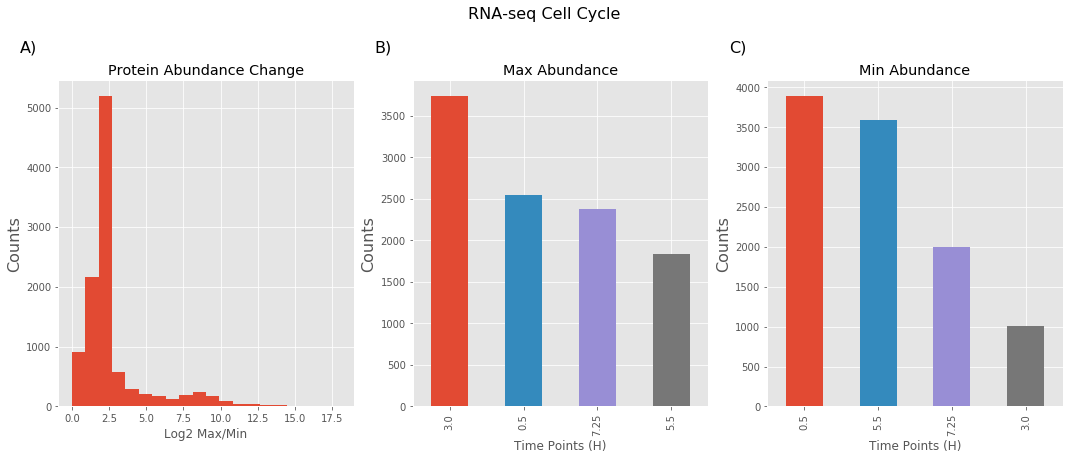

In [152]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_RNA_CellCycle_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_RNA_CellCycle_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_RNA_CellCycle_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')

plt.suptitle('RNA-seq Cell Cycle',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_12.png'))
plt.show()

##### keep trak of features created for sup table

In [153]:
feat_name = 'EF_RNA_CellCycle_min_max'
feat_dataset = 'Archer SK, 2016'
feat_pmids = '21483801'

feat_desc = '''Log2 fold change between the maximum and minimum mRNA abundance
time points during the PCF Cell Cycle'''.replace('\n','')
exp_feat.loc[25,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_RNA_CellCycle_max'
feat_dataset = 'Archer SK, 2016'
feat_desc = 'The time point with the maximum mRNA abundance during the PCF Cell Cycle'
exp_feat.loc[26,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_RNA_CellCycle_min'
feat_dataset = 'Archer SK, 2016'
feat_desc = 'The time point with the minimum mRNA abundance during the PCF Cell Cycle'
exp_feat.loc[27,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(28, 5)
True


,Feature Name,dataset,PMID,OMICs,description
23,EF_fc_glucose_2,"Qiu Y, 2018",30381351,Trascriptomics / RNA-seq,Log2 fold changes between glucose-fed and glu...
24,EF_fc_glucose_3,"Qiu Y, 2018",30381351,Trascriptomics / RNA-seq,Log2 fold changes between long slender BSF glu...
25,EF_RNA_CellCycle_min_max,"Archer SK, 2016",21483801,Trascriptomics / RNA-seq,Log2 fold change between the maximum and minim...
26,EF_RNA_CellCycle_max,"Archer SK, 2016",21483801,Trascriptomics / RNA-seq,The time point with the maximum mRNA abundance...
27,EF_RNA_CellCycle_min,"Archer SK, 2016",21483801,Trascriptomics / RNA-seq,The time point with the minimum mRNA abundance...


In [154]:
print(ml_df.shape)

(11832, 29)


#### RNA-seq BSF to PCF

Naguleswaran et al. 2018

PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/29606092">29606092</a> and 
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_b5cbc0fe92">TryTripDB</a>

This study provides the first transcriptomic data from cultures of four consecutive life-cycle stages of Trypanosoma brucei.

In [155]:
tryp_df.rename({'antisense - Long Slender - unique only':
                 '1 antisense - Long Slender - unique only',
               
                'antisense - Short Stumpy - unique only':
                 '2 antisense - Short Stumpy - unique only',
                
                'antisense - PCF Early - unique only':
                 '3 antisense - PCF Early - unique only',

                 'antisense - PCF Late - unique only':
                 '4 antisense - PCF Late - unique only',

               },
                inplace=True,axis=1)

cols = ['1 antisense - Long Slender - unique only', 
        '2 antisense - Short Stumpy - unique only',
        '3 antisense - PCF Early - unique only',
        '4 antisense - PCF Late - unique only']


print (cols)
temp_df = tryp_df[cols]
temp_df = temp_df.replace(0.0, np.nan)
ml_df['EF_RNA_BSF_to_PCF_anti_min_max'] = np.log2(
    temp_df[cols].max(axis=1,skipna=True)/temp_df[cols].min(axis=1,skipna=True))

temp_df.columns = [n.split(' ')[0] for n in cols]
cols = temp_df.columns
ml_df['EF_RNA_BSF_to_PCF_anti_max'] = temp_df[cols].idxmax(axis=1)
ml_df['EF_RNA_BSF_to_PCF_anti_max'] = [float(n) for n 
                                       in ml_df['EF_RNA_BSF_to_PCF_anti_max']]
ml_df['EF_RNA_BSF_to_PCF_anti_min'] = temp_df[cols].idxmin(axis=1)
ml_df['EF_RNA_BSF_to_PCF_anti_min'] = [float(n) for n 
                                       in ml_df['EF_RNA_BSF_to_PCF_anti_min']] 

#ml_df['RNA_CellCycle_max']=ml_df['RNA_CellCycle_max'].astype('category')
#ml_df['RNA_CellCycle_min']=ml_df['RNA_CellCycle_min'].astype('category')

['1 antisense - Long Slender - unique only', '2 antisense - Short Stumpy - unique only', '3 antisense - PCF Early - unique only', '4 antisense - PCF Late - unique only']


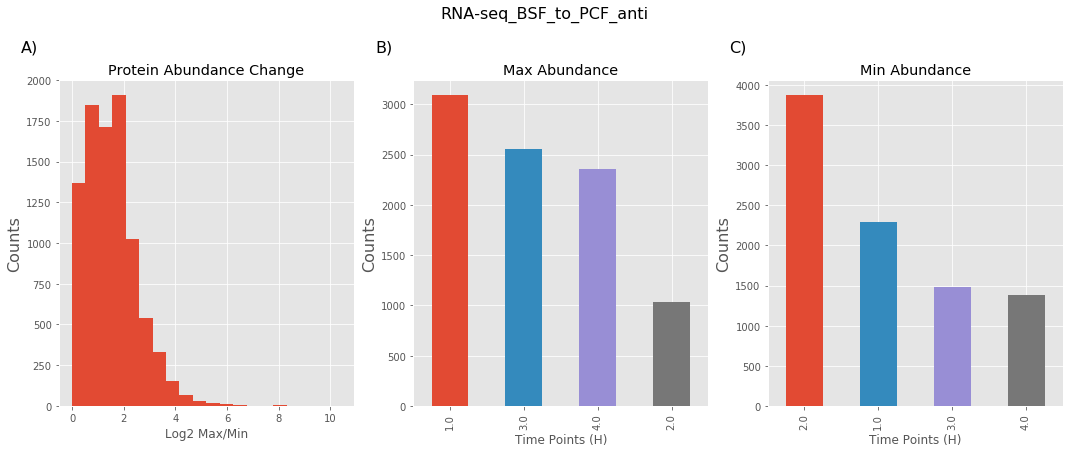

In [156]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_RNA_BSF_to_PCF_anti_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_RNA_BSF_to_PCF_anti_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_RNA_BSF_to_PCF_anti_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')

plt.suptitle('RNA-seq_BSF_to_PCF_anti',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_13.png'))
plt.show()

##### keep trak of features created for sup table

In [157]:
feat_name = 'EF_RNA_BSF_to_PCF_anti_min_max'
feat_dataset = 'Naguleswaran et al. 2018'
feat_desc = '''Log2 fold change between the maximum and minimum mRNA abundance
during the PCF to BSF differentiation, computed on the antisense strand'''.replace('\n','')
feat_pmids = '29606092'
exp_feat.loc[28,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_RNA_BSF_to_PCF_anti_max'
feat_dataset = 'Naguleswaran et al. 2018'
feat_desc = '''The time point with the maximum mRNA abundance during the PCF to BSF differentiation, 
computed on the antisense strand'''.replace('\n','')
exp_feat.loc[29,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_RNA_BSF_to_PCF_anti_min'
feat_dataset = 'Naguleswaran et al. 2018'
feat_desc = '''The time point with the minimum mRNA abundance during the PCF to BSF differentiation,
computed on the antisense strand'''
exp_feat.loc[30,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(31, 5)
True


,Feature Name,dataset,PMID,OMICs,description
26,EF_RNA_CellCycle_max,"Archer SK, 2016",21483801,Trascriptomics / RNA-seq,The time point with the maximum mRNA abundance...
27,EF_RNA_CellCycle_min,"Archer SK, 2016",21483801,Trascriptomics / RNA-seq,The time point with the minimum mRNA abundance...
28,EF_RNA_BSF_to_PCF_anti_min_max,Naguleswaran et al. 2018,29606092,Trascriptomics / RNA-seq,Log2 fold change between the maximum and minim...
29,EF_RNA_BSF_to_PCF_anti_max,Naguleswaran et al. 2018,29606092,Trascriptomics / RNA-seq,The time point with the maximum mRNA abundance...
30,EF_RNA_BSF_to_PCF_anti_min,Naguleswaran et al. 2018,29606092,Trascriptomics / RNA-seq,The time point with the minimum mRNA abundance...


In [158]:
tryp_df.rename({'sense - Long Slender - unique only':
                 '1 sense - Long Slender - unique only',
               
                'sense - Short Stumpy - unique only':
                 '2 sense - Short Stumpy - unique only',
                
                'sense - PCF Early - unique only':
                 '3 sense - PCF Early - unique only',

                 'sense - PCF Late - unique only':
                 '4 sense - PCF Late - unique only',

               },
                inplace=True,axis=1)

cols = ['1 sense - Long Slender - unique only', 
        '2 sense - Short Stumpy - unique only',
        '3 sense - PCF Early - unique only',
        '4 sense - PCF Late - unique only']



#print (cols)
temp_df = tryp_df[cols]
temp_df = temp_df.replace(0.0, np.nan)
ml_df['EF_RNA_BSF_to_PCF_sen_min_max'] = np.log2(
    temp_df[cols].max(axis=1,skipna=True)/temp_df[cols].min(axis=1,skipna=True))

temp_df.columns = [n.split(' ')[0] for n in cols]
cols = temp_df.columns
ml_df['EF_RNA_BSF_to_PCF_sen_max'] = temp_df[cols].idxmax(axis=1)
ml_df['EF_RNA_BSF_to_PCF_sen_max'] = [float(n) for n 
                                      in ml_df['EF_RNA_BSF_to_PCF_sen_max']]
ml_df['EF_RNA_BSF_to_PCF_sen_min'] = temp_df[cols].idxmin(axis=1)
ml_df['EF_RNA_BSF_to_PCF_sen_min'] = [float(n) for n 
                                      in ml_df['EF_RNA_BSF_to_PCF_sen_min']] 


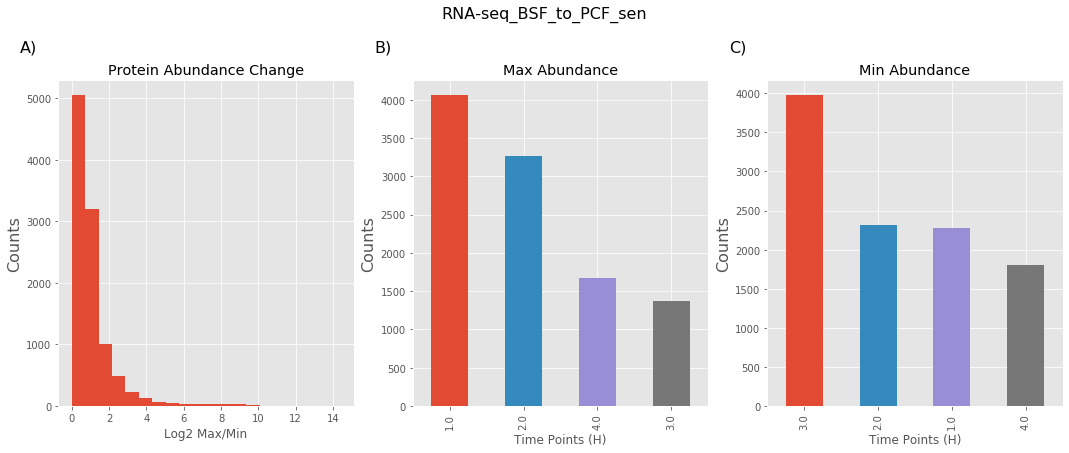

In [159]:
fig,axes=plt.subplots(figsize=(18,6),ncols=3)
ml_df['EF_RNA_BSF_to_PCF_sen_min_max'].plot(kind='hist', bins=20,ax=axes[0])
axes[0].set_xlabel('Log2 Max/Min',fontsize=12)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_title('Protein Abundance Change')
scripts.add_subplot_index(axes[0], text='A)')

ml_df['EF_RNA_BSF_to_PCF_sen_max'].value_counts().plot(kind='bar',ax=axes[1])
axes[1].set_xlabel('Time Points (H)',fontsize=12)
axes[1].set_ylabel('Counts', fontsize=16)
axes[1].set_title('Max Abundance')
scripts.add_subplot_index(axes[1], text='B)')

ml_df['EF_RNA_BSF_to_PCF_sen_min'].value_counts().plot(kind='bar',ax=axes[2])
axes[2].set_xlabel('Time Points (H)',fontsize=12)
axes[2].set_ylabel('Counts', fontsize=16)
axes[2].set_title('Min Abundance')
scripts.add_subplot_index(axes[2], text='C)')

plt.suptitle('RNA-seq_BSF_to_PCF_sen',fontsize=16,y=1.05)
#plt.savefig(os.path.join('figures','example_1','Fig_14.png'))
plt.show()

##### keep trak of features created for sup table

In [160]:
feat_name = 'EF_RNA_BSF_to_PCF_sen_min_max'

feat_desc = '''Log2 fold change between the maximum and minimum mRNA abundance
during the PCF to BSF differentiation, computed on the sense strand'''.replace('\n','')
exp_feat.loc[31,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_RNA_BSF_to_PCF_sen_max'

feat_desc = '''The time point with the maximum mRNA abundance during the PCF to BSF differentiation, 
computed on the sense strand'''.replace('\n','')
exp_feat.loc[32,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_RNA_BSF_to_PCF_sen_min'

feat_desc = '''The time point with the minimum mRNA abundance during the PCF to BSF differentiation,
computed on the sense strand'''
exp_feat.loc[33,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()


(34, 5)
True


,Feature Name,dataset,PMID,OMICs,description
29,EF_RNA_BSF_to_PCF_anti_max,Naguleswaran et al. 2018,29606092,Trascriptomics / RNA-seq,The time point with the maximum mRNA abundance...
30,EF_RNA_BSF_to_PCF_anti_min,Naguleswaran et al. 2018,29606092,Trascriptomics / RNA-seq,The time point with the minimum mRNA abundance...
31,EF_RNA_BSF_to_PCF_sen_min_max,Naguleswaran et al. 2018,29606092,Trascriptomics / RNA-seq,Log2 fold change between the maximum and minim...
32,EF_RNA_BSF_to_PCF_sen_max,Naguleswaran et al. 2018,29606092,Trascriptomics / RNA-seq,The time point with the maximum mRNA abundance...
33,EF_RNA_BSF_to_PCF_sen_min,Naguleswaran et al. 2018,29606092,Trascriptomics / RNA-seq,The time point with the minimum mRNA abundance...


#### RNA-Seq Abundance
Vasquez JJ, 2014<p>
Procyclic and bloodstream form mRNA transcriptome and ribosome profiling
PMID:<a href="https://www.ncbi.nlm.nih.gov/pubmed/24442674 ">24442674</a> and
<a href="https://tritrypdb.org/tritrypdb/app/record/dataset/DS_7252b6506e">TryTripDB</a>

In [161]:
#abundace
#[ n for n in X.columns if 'Abundance' in n]
cols = ['sense - PF mRNA', 
            'sense - PF RiboProfile', 
            'sense - BF mRNA',
            'sense - BF RiboProfile',
            ]
new_names = [
'EF_Abundance_s_PCF_mRNA',
'EF_Abundance_s_PCF_Ribo',
'EF_Abundance_s_BSF_mRNA',
'EF_Abundance_s_BSF_Ribo',     
]

In [162]:
#abundace
cols = ['sense - PF mRNA', 
            'sense - PF RiboProfile', 
            'sense - BF mRNA',
            'sense - BF RiboProfile',
            ]
new_names = [
'EF_Abundance_s_PCF_mRNA',
'EF_Abundance_s_PCF_Ribo',
'EF_Abundance_s_BSF_mRNA',
'EF_Abundance_s_BSF_Ribo',     
]
temp= tryp_df[cols]
temp= np.log10(temp[cols].replace(0,np.nan))
ml_df[cols]=temp

rename = dict(zip(cols,new_names))
ml_df.rename(rename,axis=1, inplace=True)
ml_df.shape

(11832, 39)

##### keep trak of features created for sup table

In [163]:
feat_name = 'EF_Abundance_s_PCF_mRNA'
feat_dataset = 'Vasquez JJ, 2014'
feat_pmids = '24442674'
feat_desc = '''Log10 FRPKM of mRNA in PCF, sence strand'''
exp_feat.loc[34,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]


feat_name = 'EF_Abundance_s_PCF_Ribo'
feat_desc = '''Log10 FRPKM of Ribosome Profiling in PCF, sence strand'''
exp_feat.loc[35,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_Abundance_s_BSF_mRNA'
feat_desc = '''Log10 FRPKM of mRNA in BSF, sence strand'''
exp_feat.loc[36,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]


feat_name = 'EF_Abundance_s_BSF_Ribo'
feat_desc = '''Log10 FRPKM of Ribosome Profiling in BSF, sence strand'''
exp_feat.loc[37,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]



print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(38, 5)
True


,Feature Name,dataset,PMID,OMICs,description
33,EF_RNA_BSF_to_PCF_sen_min,Naguleswaran et al. 2018,29606092,Trascriptomics / RNA-seq,The time point with the minimum mRNA abundance...
34,EF_Abundance_s_PCF_mRNA,"Vasquez JJ, 2014",24442674,Trascriptomics / RNA-seq,"Log10 FRPKM of mRNA in PCF, sence strand"
35,EF_Abundance_s_PCF_Ribo,"Vasquez JJ, 2014",24442674,Trascriptomics / RNA-seq,"Log10 FRPKM of Ribosome Profiling in PCF, senc..."
36,EF_Abundance_s_BSF_mRNA,"Vasquez JJ, 2014",24442674,Trascriptomics / RNA-seq,"Log10 FRPKM of mRNA in BSF, sence strand"
37,EF_Abundance_s_BSF_Ribo,"Vasquez JJ, 2014",24442674,Trascriptomics / RNA-seq,"Log10 FRPKM of Ribosome Profiling in BSF, senc..."


In [164]:
#differential abundace
cols = ['sense - PF mRNA', 
            'sense - PF RiboProfile', 
            'sense - BF mRNA',
            'sense - BF RiboProfile',
            ]
temp= tryp_df[cols]
temp= temp[cols].replace(0,np.nan)
temp['mRNA_BSF_vs_PCF'] = np.log2(temp['sense - BF mRNA']/
                                  temp['sense - PF mRNA'])
temp['RiboP_BSF_vs_PCF'] = np.log2(temp['sense - BF RiboProfile']/
                                   temp['sense - PF RiboProfile'])
ml_df[['EF_mRNA_BSF_vs_PCF',
       'EF_RiboP_BSF_vs_PCF']]=temp[['mRNA_BSF_vs_PCF',
                                     'RiboP_BSF_vs_PCF']]
del temp
gc.collect()
ml_df.shape

(11832, 41)

##### keep trak of features created for sup table

In [165]:
feat_name = 'mRNA_BSF_vs_PCF'
feat_desc = '''Log2 fold change of mRNA (FRPKM) between BSF and PCF'''
exp_feat.loc[38,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_desc = '''Log2 fold change ribosome profiling abundance (FRPKM) between BSF and PCF'''
exp_feat.loc[39,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()


(40, 5)
True


,Feature Name,dataset,PMID,OMICs,description
35,EF_Abundance_s_PCF_Ribo,"Vasquez JJ, 2014",24442674,Trascriptomics / RNA-seq,"Log10 FRPKM of Ribosome Profiling in PCF, senc..."
36,EF_Abundance_s_BSF_mRNA,"Vasquez JJ, 2014",24442674,Trascriptomics / RNA-seq,"Log10 FRPKM of mRNA in BSF, sence strand"
37,EF_Abundance_s_BSF_Ribo,"Vasquez JJ, 2014",24442674,Trascriptomics / RNA-seq,"Log10 FRPKM of Ribosome Profiling in BSF, senc..."
38,mRNA_BSF_vs_PCF,"Vasquez JJ, 2014",24442674,Trascriptomics / RNA-seq,Log2 fold change of mRNA (FRPKM) between BSF a...
39,mRNA_BSF_vs_PCF,"Vasquez JJ, 2014",24442674,Trascriptomics / RNA-seq,Log2 fold change ribosome profiling abundance ...


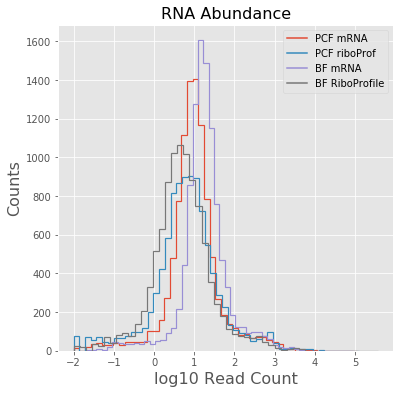

In [166]:

fig,ax=plt.subplots(figsize=(6,6))
from matplotlib.lines import Line2D
ml_df['EF_Abundance_s_PCF_mRNA'].plot(kind='hist',histtype='step', 
                               ax=ax, label='PCF mRNA',linewidth=1.2,bins=50)
ml_df['EF_Abundance_s_PCF_Ribo'].plot(kind='hist',histtype='step',
                                      ax=ax, label='PCF riboProf',
                                      linewidth=1.2,bins=50)
ml_df['EF_Abundance_s_BSF_mRNA'].plot(kind='hist',histtype='step', ax=ax,
                               label='BF mRNA',linewidth=1.2,bins=50)
ml_df['EF_Abundance_s_BSF_Ribo'].plot(kind='hist',histtype='step', 
                                      ax=ax, label='BF RiboProfile',
                                      linewidth=1.2,bins=50)

plt.xlabel('log10 Read Count', fontsize=16)
plt.ylabel('Counts', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels)
plt.title('RNA Abundance',fontsize=16)
#plt.savefig(os.path.join('figures','example_1','Fig_15.png'))
plt.show()

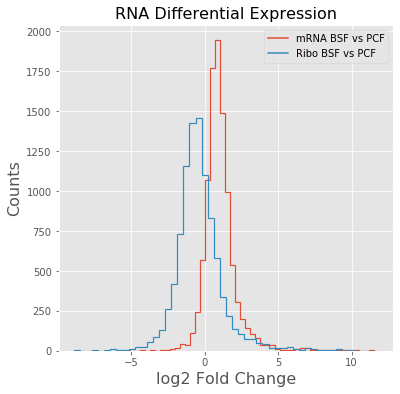

In [167]:
fig,ax=plt.subplots(figsize=(6,6))
from matplotlib.lines import Line2D
ml_df['EF_mRNA_BSF_vs_PCF'].plot(kind='hist',histtype='step', 
                                 ax=ax, label='mRNA BSF vs PCF',
                                 linewidth=1.2,bins=50)
ml_df['EF_RiboP_BSF_vs_PCF'].plot(kind='hist',histtype='step',
                                  ax=ax, label='Ribo BSF vs PCF',
                                  linewidth=1.2,bins=50)
plt.xlabel('log2 Fold Change', fontsize=16)
plt.ylabel('Counts', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
plt.legend(handles=new_handles, labels=labels)
plt.title('RNA Differential Expression',fontsize=16)
#plt.savefig(os.path.join('figures','example_1','Fig_16.png'))
plt.show()


### More feature from TritrypDB 

The next columns / sequence features do not need preprocessing, we just transfer these features to our ML dataset

The changes in RNA abundance after overexpressing the wild type RNA helicase DHH1, or after expressing a mutant form of this protein, have been investigating with a cDNA microarrays strategy. The dataset is reported in TriTrypDB as the log2 fold changes in signal intensity between the wild type versus the experimentally induced conditions. For this reason, the dataset was transferred over the ML dataset without further processing. A similar cDNA microarray strategy was used to study the T. brucei response to heat shock and the log2 fold changes between the wild type and treated condition were transferred over to the ML dataset. Similarly, the log2 fold change values of protein abundances (evaluated with label-free mass spectrometry) between the PCF nuclei and the whole-cell lysates were transferred over to the ML dataset. 
All the features described above were derived from experimental evidence, for this reason the names are preceded by an ‘EF’ (Experimental Feature) prefix for easier identification.


In [168]:
cols =[
    #experiment features
    'DEAD:DQAD mutant - DHH1 mutant induced vs control (Tb427 DHH1 induced)',
    'heatShock_vs_control (heat shock treated)',
    'wild type - wild type induced vs control (Tb427 DHH1 induced)',
    'Nuclear Enriched Sample (Tb927 Nuc Prot)',
]

rename = {
    'DEAD:DQAD mutant - DHH1 mutant induced vs control (Tb427 DHH1 induced)':
    'EF_DHH1_mutant',
    
    'heatShock_vs_control (heat shock treated)':
    'EF_heatShock',
    
    'wild type - wild type induced vs control (Tb427 DHH1 induced)':
    'EF_DHH1_induced',

    'Nuclear Enriched Sample (Tb927 Nuc Prot)':
    'EF_Nuclear_enriched',}


ml_df[cols]=tryp_df[cols]
ml_df.rename(rename, axis=1, inplace=True)

ml_df.shape

(11832, 45)

##### keep trak of features created for sup table

In [169]:
feat_name = 'EF_DHH1_mutant'
feat_dataset = 'Kramer S et al. 2010'
feat_pmids = '20124414'
feat_desc = '''The log2 difference in mRNA aboundance between the wild type and DHH1 mutant overexpressing cells'''
feat_type='Trascriptomics / microarray'
exp_feat.loc[41,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_DHH1_induced'
feat_desc = '''The log2 difference in mRNA aboundance between the wild type and DHH1 overexpressing cells'''
exp_feat.loc[42,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'EF_heatShock'
feat_dataset = 'Kramer S et al. 2009'
feat_pmids = '18713834'
feat_desc = '''The log2 difference in mRNA aboundance between the wild type and  heat shock induced cells'''
exp_feat.loc[43,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]


feat_name = 'EF_Nuclear_enriched'
feat_dataset = 'Goos C et al 2017'
feat_pmids = '28727848'
feat_desc = '''Log2 fold change values in protein abundances between purified PCF nuclei and the whole-cell lysates'''
feat_type='Proteomics'
exp_feat.loc[44,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]


print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(44, 5)
True


,Feature Name,dataset,PMID,OMICs,description
39,mRNA_BSF_vs_PCF,"Vasquez JJ, 2014",24442674,Trascriptomics / RNA-seq,Log2 fold change ribosome profiling abundance ...
41,EF_DHH1_mutant,Kramer S et al. 2010,20124414,Trascriptomics / microarray,The log2 difference in mRNA aboundance between...
42,EF_DHH1_induced,Kramer S et al. 2010,20124414,Trascriptomics / microarray,The log2 difference in mRNA aboundance between...
43,EF_heatShock,Kramer S et al. 2009,18713834,Trascriptomics / microarray,The log2 difference in mRNA aboundance between...
44,EF_Nuclear_enriched,Goos C et al 2017,28727848,Proteomics,Log2 fold change values in protein abundances ...


## Sequence Based Features

### Ortholog / Paralog
Ortholog and Paralog count can be directly transfer to our ml dataset as computed by the 
<a href="https://orthomcl.org/orthomcl/">orthomcl</a> database

In [170]:
ml_df[['SF_Ortholog_count',
    'SF_Paralog_count']]=tryp_df[['Ortholog count',
    'Paralog count']]

##### keep trak of features created for sup table

In [171]:
feat_name = 'SF_Ortholog_count'
feat_dataset = 'Fischer S et al. 2011'
feat_pmids = '21901743'
feat_desc = '''The number Ortholog genes identified in the orthomcl database'''
feat_type='Sequence Feature'
exp_feat.loc[45,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]


feat_name = 'SF_Paralog_count'
feat_desc = '''The number Paralog genes identified in the orthomcl database'''
exp_feat.loc[46,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(46, 5)
True


,Feature Name,dataset,PMID,OMICs,description
42,EF_DHH1_induced,Kramer S et al. 2010,20124414,Trascriptomics / microarray,The log2 difference in mRNA aboundance between...
43,EF_heatShock,Kramer S et al. 2009,18713834,Trascriptomics / microarray,The log2 difference in mRNA aboundance between...
44,EF_Nuclear_enriched,Goos C et al 2017,28727848,Proteomics,Log2 fold change values in protein abundances ...
45,SF_Ortholog_count,Fischer S et al. 2011,21901743,Sequence Feature,The number Ortholog genes identified in the or...
46,SF_Paralog_count,Fischer S et al. 2011,21901743,Sequence Feature,The number Paralog genes identified in the ort...


### Signal Peptide
TriTrypDB reports the presence of a signal peptide in the proteome of T. brucei by using the SignalP3-NN and SignalP-HMM alghorithms implementend in SignalP 3.0. The SignalP3-NN alghoritm produces two scores (S-mean and the D-score, NN Sum, NN D), while the HMM alghorithms output one score (HMM Prob). To create just one descriptor for the presence of a signal peptide, we average the D and HMM prob score.  

In [172]:
#processing of the signal peptide data
from sklearn.preprocessing import minmax_scale
def parse_signal_ip(X):
    if str(X).strip() != str(np.nan):
        temp = [n.strip() for n in X.split(', ')]
        score_a = float(temp[0].split(':')[1].strip())
        score_b = float(temp[1].split(':')[1].strip())   
        score_c = float(temp[2].split(':')[1].strip())
        return score_a,score_b,score_c
    else:
        return 0, 0, 0

temp = pd.DataFrame()
temp["sig_S-mean"], temp["sig_D-score"], temp["sig_HMM"] = zip(*tryp_df['SignalP Scores'].apply(
    lambda val: parse_signal_ip(val)))
temp['ave']=temp.iloc[:,1:3].median(axis=1)
print(temp[temp['ave']>0].corr())
temp[temp['ave']>0].describe()

             sig_S-mean  sig_D-score   sig_HMM       ave
sig_S-mean     1.000000     0.836252  0.251789  0.577119
sig_D-score    0.836252     1.000000  0.381395  0.747799
sig_HMM        0.251789     0.381395  1.000000  0.898947
ave            0.577119     0.747799  0.898947  1.000000


,sig_S-mean,sig_D-score,sig_HMM,ave
count,2661.000000,2661.000000,2661.000000,2661.000000
mean,3.130402,0.602390,0.812976,0.707683
std,1.221017,0.178424,0.270421,0.188260
min,0.000000,0.060000,0.000000,0.170000
25%,3.000000,0.490000,0.730000,0.585000
50%,4.000000,0.620000,0.950000,0.770000
75%,4.000000,0.740000,0.990000,0.855000
max,4.000000,0.940000,1.000000,0.965000


In [173]:
ml_df['SF_Sig_Pep']=temp['ave']

##### keep trak of features created for sup table

In [174]:
feat_name = 'SF_Sig_Pep'
feat_dataset = 'Bendtsen JD et al. 2004'
feat_pmids = '15223320'
feat_desc = '''Avearge of the D and HMM score implemented in the SignalP3-NN alghoritm, precomputed by TriTrypDB team'''
feat_type='Sequence Feature'
exp_feat.loc[47,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(47, 5)
True


,Feature Name,dataset,PMID,OMICs,description
43,EF_heatShock,Kramer S et al. 2009,18713834,Trascriptomics / microarray,The log2 difference in mRNA aboundance between...
44,EF_Nuclear_enriched,Goos C et al 2017,28727848,Proteomics,Log2 fold change values in protein abundances ...
45,SF_Ortholog_count,Fischer S et al. 2011,21901743,Sequence Feature,The number Ortholog genes identified in the or...
46,SF_Paralog_count,Fischer S et al. 2011,21901743,Sequence Feature,The number Paralog genes identified in the ort...
47,SF_Sig_Pep,Bendtsen JD et al. 2004,15223320,Sequence Feature,Avearge of the D and HMM score implemented in ...


### Distance from thelomer and position in the polycistronic transcript
The GFF file available in the TriTrypDB database for T. brucei TREU927 was downloaded and analysed to create a descriptor reporting the distance of a gene transcript from its polycystron starting site [31]. Polycystron boundaries were chosen based on changes in transcript orientation. 

In [175]:
#read the gff file and process    
infile=os.path.join('input','TriTrypDB-45_TbruceiTREU927.gff')
source_size = get_source_size(infile=infile)
count=count_comment_line(infile=infile)
gff = pd.read_table(infile,skiprows=count,header=None)
columns = ['seqname','source','feature','start','end',
           'score','strand','frame','attribute']
gff.columns = columns
gff=gff[gff.feature=='gene']
gff['gene_id']=[get_attributes(n)['ID'] for n in gff.attribute]
gff.drop(['attribute','score','frame','source','feature'],inplace=True,axis=1)


gff.sort_values(['seqname','start'],inplace=True)
gff['cds_middle']=(gff['start']+gff['end'])/2
gff['cds_middle']=gff['cds_middle'].astype(int)
gff['cds_lenght']=gff['end']-gff['start']
gff['norm_pos']=[float(a)/source_size[b] for a,b in zip(gff.cds_middle,gff.seqname)]

#shift the dataframe to capture when the genes change plolycistron
gff['strand_shift'] = gff.strand.shift(1)
gff['change']=gff['strand_shift']==gff['strand']

polycistronic_id = []
count=0
for a,b in zip(gff.seqname, gff.change):
    if b:
        polycistronic_id.append(count)
    else:
        polycistronic_id.append(count+1)
        count+=1
gff['polycistron_id'] = [a+'_'+str(b) for a,b in zip(gff.seqname, polycistronic_id)]
temp_g = gff.groupby(['polycistron_id'])
temp_g = temp_g['start'].max()-temp_g['start'].min()
polycistron_sizes = temp_g.to_dict()
gff['polycistron_size']=[polycistron_sizes[n] for n in gff['polycistron_id']]
temp_g = gff.groupby(['polycistron_id'])
gff['polycistron_cds_start']=temp_g['cds_lenght'].cumsum()
gff['polycistron_norm_pos']=gff['polycistron_cds_start']/gff['polycistron_size']
#gff['polycistron_size']=
gff.drop_duplicates(subset=['gene_id'],inplace=True)
gff.set_index('gene_id',inplace=True)
gff[1000:2000].head(10)

,seqname,start,end,strand,cds_middle,cds_lenght,norm_pos,strand_shift,change,polycistron_id,polycistron_size,polycistron_cds_start,polycistron_norm_pos
gene_id,,,,,,,,,,,,,
Tb927.3.1930,Tb927_03_v5.1,508299,509783,-,509041,1484,0.307908,-,True,Tb927_03_v5.1_65,196568,96120,0.488991
Tb927.3.1940,Tb927_03_v5.1,510641,511970,-,511305,1329,0.309277,-,True,Tb927_03_v5.1_65,196568,97449,0.495752
Tb927.3.1955,Tb927_03_v5.1,513487,514034,-,513760,547,0.310762,-,True,Tb927_03_v5.1_65,196568,97996,0.498535
Tb927.3.1960,Tb927_03_v5.1,514271,515762,-,515016,1491,0.311522,-,True,Tb927_03_v5.1_65,196568,99487,0.506120
Tb927.3.1970,Tb927_03_v5.1,516166,517317,-,516741,1151,0.312565,-,True,Tb927_03_v5.1_65,196568,100638,0.511975
Tb927.3.1980,Tb927_03_v5.1,517473,518492,-,517982,1019,0.313316,-,True,Tb927_03_v5.1_65,196568,101657,0.517159
Tb927.3.1990,Tb927_03_v5.1,518617,520892,-,519754,2275,0.314388,-,True,Tb927_03_v5.1_65,196568,103932,0.528733
Tb927.3.2000,Tb927_03_v5.1,521498,522203,-,521850,705,0.315656,-,True,Tb927_03_v5.1_65,196568,104637,0.532320
Tb927.3.2010,Tb927_03_v5.1,522343,524255,-,523299,1912,0.316532,-,True,Tb927_03_v5.1_65,196568,106549,0.542047


In [176]:
#add the new features
print(ml_df.shape)
ml_df=ml_df.join(gff[[#'norm_pos', 'polycistron_cds_start',
                      'polycistron_norm_pos']], how='left', on='Gene ID')
print(ml_df.shape)

(11832, 48)
(11832, 49)


In [177]:
ml_df.rename({'polycistron_norm_pos':'SF_Polycistron_Start'}, axis=1, inplace=True)

##### keep trak of features created for sup table

In [178]:
feat_name = 'SF_Polycistron_Start'
feat_dataset = 'na'
feat_pmids = 'na'
feat_desc = '''Starting point of the gene respect to the policystronic transcript that belongs to'''
feat_type='Sequence Feature'
exp_feat.loc[48,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(48, 5)
True


,Feature Name,dataset,PMID,OMICs,description
44,EF_Nuclear_enriched,Goos C et al 2017,28727848,Proteomics,Log2 fold change values in protein abundances ...
45,SF_Ortholog_count,Fischer S et al. 2011,21901743,Sequence Feature,The number Ortholog genes identified in the or...
46,SF_Paralog_count,Fischer S et al. 2011,21901743,Sequence Feature,The number Paralog genes identified in the ort...
47,SF_Sig_Pep,Bendtsen JD et al. 2004,15223320,Sequence Feature,Avearge of the D and HMM score implemented in ...
48,SF_Polycistron_Start,na,na,Sequence Feature,Starting point of the gene respect to the poli...


### Transmembrane Domains

In [179]:
#Anoter normalization for the trans-membrane domain
ml_df['SF_TMD']=tryp_df['# TM Domains']/tryp_df['Transcript Length']
ml_df['SF_Transcript_Length'] = np.log(tryp_df['Transcript Length'])

##### keep trak of features created for sup table

In [180]:
feat_name = 'SF_TMD'
feat_dataset = 'na'
feat_pmids = 'na'
feat_desc = '''The number of transmembrane domains divided by the Transcript Length'''
feat_type='Sequence Feature'
exp_feat.loc[49,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'SF_Transcript_Length'
feat_desc = '''The Log10 of the Transcript Length'''
feat_type='Sequence Feature'
exp_feat.loc[50,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]


print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(50, 5)
True


,Feature Name,dataset,PMID,OMICs,description
46,SF_Paralog_count,Fischer S et al. 2011,21901743,Sequence Feature,The number Paralog genes identified in the ort...
47,SF_Sig_Pep,Bendtsen JD et al. 2004,15223320,Sequence Feature,Avearge of the D and HMM score implemented in ...
48,SF_Polycistron_Start,na,na,Sequence Feature,Starting point of the gene respect to the poli...
49,SF_TMD,na,na,Sequence Feature,The number of transmembrane domains divided by...
50,SF_Transcript_Length,na,na,Sequence Feature,The Log10 of the Transcript Length


### SNPs

In [181]:
#Normalization of the SNPs data
for c in [
    'Non-Coding SNPs All Strains',
    'NonSynonymous SNPs All Strains', 
    'SNPs with Stop Codons All Strains', 
    'Synonymous SNPs All Strains', 
    'Total SNPs All Strains']:
    ml_df[c]=tryp_df[c]/tryp_df['Transcript Length']


#ml_df['NonSyn/Syn SNP Ratio All Strains']=tryp_df['NonSynonymous SNPs All Strains']/(tryp_df['NonSynonymous SNPs All Strains']+tryp_df['Synonymous SNPs All Strains'])    
ml_df['NonSyn/Syn SNP Ratio All Strains']=tryp_df['NonSyn/Syn SNP Ratio All Strains']


In [182]:
rename = {
    'Non-Coding SNPs All Strains':'SF_SNPs1',
    'NonSynonymous SNPs All Strains':'SF_SNPs2', 
    'SNPs with Stop Codons All Strains':'SF_SNPs3', 
    'Synonymous SNPs All Strains':'SF_SNPs4', 
    'Total SNPs All Strains':'SF_SNPs5',
    'NonSyn/Syn SNP Ratio All Strains':'SF_SNPs6'}

ml_df.rename(rename, axis=1, inplace=True)

##### keep trak of features created for sup table

In [183]:
feat_name = 'SF_SNPs1'
feat_dataset = 'na'
feat_pmids = 'na'
feat_desc = '''The number of Non-Coding SNPs in all Strains divided by the Transcript Length'''
feat_type='Sequence Feature'
exp_feat.loc[51,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'SF_SNPs2'
feat_desc = '''The number of NonSynonymous SNPs in all Strains divided by the Transcript Length'''
exp_feat.loc[52,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'SF_SNPs3'
feat_desc = '''The number of SNPs with Stop Codons in all Strains divided by the Transcript Length'''
exp_feat.loc[53,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'SF_SNPs4'
feat_desc = '''The number of Synonymous SNPs in all Strains divided by the Transcript Length'''
exp_feat.loc[54,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'SF_SNPs5'
feat_desc = '''The Total SNPs in all Strains divided by the Transcript Length'''
exp_feat.loc[55,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

feat_name = 'SF_SNPs6'
feat_desc = '''The ration of NonSyn/Syn SNPs in all Strains'''
exp_feat.loc[56,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(56, 5)
True


,Feature Name,dataset,PMID,OMICs,description
52,SF_SNPs2,na,na,Sequence Feature,The number of NonSynonymous SNPs in all Strain...
53,SF_SNPs3,na,na,Sequence Feature,The number of SNPs with Stop Codons in all Str...
54,SF_SNPs4,na,na,Sequence Feature,The number of Synonymous SNPs in all Strains d...
55,SF_SNPs5,na,na,Sequence Feature,The Total SNPs in all Strains divided by the T...
56,SF_SNPs6,na,na,Sequence Feature,The ration of NonSyn/Syn SNPs in all Strains


### Coding transcripts

In [184]:
#adding binary value, protein coding or not
def get_prop(desc):
    desc=desc.split('|')
    desc = [n.strip().split('=') for n in desc][1:]
    desc = dict(zip([n[0] for n in desc],[n[1] for n in desc]))
    return(desc['gene'])
      
infile=os.path.join('input','TriTrypDB-45_TbruceiTREU927_AnnotatedProteins.fasta')
handle = open(infile, "rU")
prot_cod = []
for record in SeqIO.parse(handle, "fasta"):
    #print(record.id)
    prot_cod.append(get_prop(record.description))
prot_cod=set(prot_cod)  
ml_df['SF_Prot_Coding']=[1 if n in prot_cod else 0 for n in ml_df['Gene ID']]
ml_df['SF_Prot_Coding'].value_counts()

1    11203
0      629
Name: SF_Prot_Coding, dtype: int64

##### keep trak of features created for sup table

In [185]:
feat_name = 'SF_Prot_Coding'
feat_desc = '''Binary value describing if the gene is protein coding (1) or not (0)'''
exp_feat.loc[57,:]=[feat_name,feat_dataset,feat_pmids,feat_type,feat_desc]

print(exp_feat.shape)
print(exp_feat.shape[0] == ml_df.shape[1]-1)
exp_feat.tail()

(57, 5)
True


,Feature Name,dataset,PMID,OMICs,description
53,SF_SNPs3,na,na,Sequence Feature,The number of SNPs with Stop Codons in all Str...
54,SF_SNPs4,na,na,Sequence Feature,The number of Synonymous SNPs in all Strains d...
55,SF_SNPs5,na,na,Sequence Feature,The Total SNPs in all Strains divided by the T...
56,SF_SNPs6,na,na,Sequence Feature,The ration of NonSyn/Syn SNPs in all Strains
57,SF_Prot_Coding,na,na,Sequence Feature,Binary value describing if the gene is protein...


### Finalize Feature Table

In [186]:
exp_feat.to_csv(os.path.join('output','FeatureTable.csv'))

### ELM linear motif

Finally, from the ELM database [32], we downloaded the eukaryotic linear motifs, and we create a descriptor for each linear motif, reporting the number of motif instances in the primary sequence of the T. brucei proteome. With this final step, we ended up with a ML dataset of 1407 descriptors. 

In [187]:
import re

def find_motif(prot,motif):
    return len(motif.findall(prot))

infile=os.path.join('input', 'elm_classes.tsv')
count=count_comment_line(infile=infile, tag='#')
elm = pd.read_table(infile,skiprows=count)
elm.head()
elm_dict = {}
for r,s in zip(elm.ELMIdentifier, elm.Regex):
    elm_dict[r]=re.compile(s)

motif_dict={}
infile=os.path.join('input',
                    'TriTrypDB-45_TbruceiTREU927_AnnotatedProteins.fasta')
handle = open(infile, "rU")    
for record in SeqIO.parse(handle, "fasta"):
    temp_id = clean_id (record.id)
    seq = str(record.seq)
    res = [find_motif(seq, motif) for motif in elm_dict.values()]
    #print (res)
    motif_dict[temp_id]=res

motif_dict = pd.DataFrame.from_dict(motif_dict,orient='index')           
motif_dict.head()
motif_dict.columns = elm_dict.keys()

motif_dict['ELM_CLV'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('CLV')]].sum(axis=1)
motif_dict['ELM_DEG'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('DEG')]].sum(axis=1)
motif_dict['ELM_DOC'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('DOC')]].sum(axis=1)
motif_dict['ELM_LIG'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('LIG')]].sum(axis=1)
motif_dict['ELM_MOD'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('MOD')]].sum(axis=1)
motif_dict['ELM_TRG'] = motif_dict[
    [n for n in motif_dict.columns if n.startswith('TRG')]].sum(axis=1)
print(motif_dict.head())

#add the features
print(ml_df.shape)
motif_dict.columns = [n if n.startswith('ELM_') else 'ELM_'+n for n in motif_dict.columns]

ml_df=ml_df.join(motif_dict, how='left', on='Gene ID')
print(ml_df.shape)

              CLV_C14_Caspase3-7  CLV_MEL_PAP_1  CLV_NRD_NRD_1  \
Tb927.1.05                     4              0              3   
Tb927.1.1000                   2              0              1   
Tb927.1.100                    0              0              6   
Tb927.1.1010                   3              0              4   
Tb927.1.1020                   2              0              1   

              CLV_PCSK_FUR_1  CLV_PCSK_KEX2_1  CLV_PCSK_PC1ET2_1  \
Tb927.1.05                 0                2                  1   
Tb927.1.1000               0                3                  2   
Tb927.1.100                1                3                  0   
Tb927.1.1010               1                4                  2   
Tb927.1.1020               0                1                  0   

              CLV_PCSK_PC7_1  CLV_PCSK_SKI1_1  CLV_Separin_Fungi  \
Tb927.1.05                 0                5                  0   
Tb927.1.1000               0               11             

### ProFET 
(https://github.com/ddofer/ProFET)
We further complemented our ML dataset by using the ProFET package to extracts hundreds of features covering the elementary biophysical and sequence-derived attributes of the T. brucei proteome [30]. 

In [188]:
fasta_file = os.path.join('input',
                          'TriTrypDB-45_TbruceiTREU927_AnnotatedProteins.fasta')

instances = len([n for n in SeqIO.parse(fasta_file, 'fasta')])
print(instances)

11203


In [189]:
#create a list of sequence,id to compute in parallel 
compute_list = []
for index,record in tqdm_notebook(
    enumerate(SeqIO.parse(fasta_file, 'fasta')), total=instances ):
        sequence = str(record.seq)
        temp_id = record.id
        compute_list.append((sequence,temp_id))        

#### Multiprocessing

In [190]:
#the code run only if the profet output file is 
#not present in the input folder

#time to use some machine power
#this is a workaround to do 
#multiprocessing using notebooks on windows
from mylib import get_features
import time
import multiprocessing as mp
cores = mp.cpu_count()
print('using', cores, 'cores')
if __name__=="__main__":
    if not os.path.exists(os.path.join('input','profet.csv.gz')):
        start_time = time.time()
        p = mp.Pool(cores)
        function_results = p.map(get_features.compute, compute_list)
        p.close()
        print("--- %s seconds ---" % (time.time() - start_time))

        function_results = pd.concat(function_results, axis=1)
        function_results = function_results.T
        function_results.dropna(axis=0,how ='all',inplace=True)
        function_results.to_csv(os.path.join('input','profet.csv.gz'), compression='gzip')
        print(function_results.head())

using 12 cores


#### one core

In [191]:
if not os.path.exists(os.path.join('input','profet.csv.gz')):
    function_results = [get_features.compute(n) for n in tqdm_notebook(compute_list)]
    function_results = pd.concat(function_results, axis=1)
    function_results = function_results.T
    function_results.dropna(axis=0,how ='all',inplace=True) 
    function_results.to_csv(os.path.join('input','profet.csv.gz'), compression='gzip') 
    function_results.head() 

In [192]:
def prepare_profet(infile=os.path.join('input','profet.csv.gz')):
    df = pd.read_csv(infile)
    df['Gene ID'] = [clean_id(n) for n in df['protein']]
    df.drop_duplicates(subset=['Gene ID'],inplace=True)
    df.set_index('Gene ID',inplace=True,drop=True)
    del df['protein']
    #we now remove sequence features with high correlation
    df_corr = df.corr().abs()
    upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.98)]
    df.drop(to_drop,axis=1,inplace=True)
    return df


temp =  prepare_profet()
#already present in the output of TriTrypDB
temp['Molecular Weight'] = np.log10(temp['Molecular Weight'])
#final_df.drop(temp.columns,axis=1,inplace=True)
temp.columns = ['PF_'+n for n in temp.columns]
print(ml_df.shape)
ml_df=ml_df.join(temp, how='left', on='Gene ID')
print(ml_df.shape)

(11832, 343)
(11832, 1403)


### Finalize dataset

In [193]:
ml_df.head()
#cast the values onto smaller size
ml_df = scripts.reduce_mem_usage(ml_df)

Memory usage of dataframe is 126.65 MB



Memory usage after optimization is: 63.72 MB
Decreased by 49.7%


In [194]:
ml_df=ml_df.drop_duplicates('Gene ID')

#save for later
ml_df.to_csv(os.path.join('output', 'final_df.csv.gz'), compression='gzip')

In [196]:
ml_df.head()

,Gene ID,EF_merged_PCF_BSF,EF_LSvSS,EF_CellCycle_min_max,EF_CellCycle_max,EF_CellCycle_min,EF_Abundance_BSF,EF_Abundance_PCF,EF_MW_fc,EF_in_complex,...,PF_ofer_w8: D Entropy,PF_ofer_w8: F Entropy,PF_ofer_w8: G Entropy,PF_ofer_w8: K Entropy,PF_ofer_w8: M Entropy,PF_ofer_w8: N Entropy,PF_ofer_w8: Total Entropy,PF_polarizability aaScale - Window size:17 Average-Trimmed MAX,PF_polarizability aaScale - Window size:17 MAXIMUM,PF_polarizability aaScale - Window size:7 MAXIMUM
0,Tb04.24M18.150,0.402849,NaN,0.000000,0.5,0.5,5.870638,7.631145,229.805298,-1.0,...,2.880418,2.385654,3.339850,2.754888,3.432959,3.252387,2.844283,0.143641,0.170043,0.184429
1,Tb04.3I12.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-1.0,...,4.653442,1.405515,2.990477,2.846087,3.916477,2.916477,2.618204,0.173773,0.199140,0.200857
2,Tb05.30F7.410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-1.0,...,3.313416,3.152952,2.645992,2.493989,3.593524,3.152952,2.916539,0.141305,0.163202,0.169000
3,Tb05.5K5.10,NaN,NaN,NaN,NaN,NaN,7.606765,7.829130,0.000000,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Tb05.5K5.100,NaN,NaN,0.263034,11.0,10.0,6.758570,7.772564,20.888992,-1.0,...,3.008562,2.941448,3.493989,2.645992,3.008562,2.313416,2.864546,0.137756,0.165388,0.176571


In [1]:
!jupyter nbconvert --to html_toc TriTrypDB_ML_1.0.ipynb

[NbConvertApp] Converting notebook TriTrypDB_ML_1.0.ipynb to html_toc
[NbConvertApp] Support files will be in TriTrypDB_ML_1.0_files\
[NbConvertApp] Making directory TriTrypDB_ML_1.0_files
[NbConvertApp] Making directory TriTrypDB_ML_1.0_files
[NbConvertApp] Making directory TriTrypDB_ML_1.0_files
[NbConvertApp] Making directory TriTrypDB_ML_1.0_files
[NbConvertApp] Making directory TriTrypDB_ML_1.0_files
[NbConvertApp] Making directory TriTrypDB_ML_1.0_files
[NbConvertApp] Making directory TriTrypDB_ML_1.0_files
[NbConvertApp] Making directory TriTrypDB_ML_1.0_files
[NbConvertApp] Making directory TriTrypDB_ML_1.0_files
[NbConvertApp] Making directory TriTrypDB_ML_1.0_files
[NbConvertApp] Making directory TriTrypDB_ML_1.0_files
[NbConvertApp] Making directory TriTrypDB_ML_1.0_files
[NbConvertApp] Making directory TriTrypDB_ML_1.0_files
[NbConvertApp] Making directory TriTrypDB_ML_1.0_files
[NbConvertApp] Making directory TriTrypDB_ML_1.0_files
[NbConvertApp] Making directory TriTrypDB